### <b>실전 프로젝트 - CNN을 활용한 풍경(Scene) 이미지 분류</b>

* 한 장의 풍경 이미지가 주어졌을 때, 어떠한 카테고리(category)에 속하는지 맞히는 <b>분류 모델</b>을 만드세요.
* 다음의 세 가지 대표적인 CNN 모델을 실습합니다.
    1. [LeNet (1998)](http://yann.lecun.com/exdb/publis/pdf/lecun-98.pdf)
    2. [AlexNet (2012 NIPS)](https://papers.nips.cc/paper/2012/file/c399862d3b9d6b76c8436e924a68c45b-Paper.pdf)
    3. [ResNet (2016 CVPR)](https://arxiv.org/abs/1512.03385)
* 성능을 올릴 수 있는 두 가지 심화 기법을 실습합니다.
    1. [Mixup (ICLR 2018)](https://arxiv.org/abs/1710.09412): 데이터 증진 기법의 일종으로 정확도를 높입니다.
    2. Transfer Learning: 학습 속도와 정확도를 모두 향상시킬 수 있습니다.
* 본 프로젝트는 <b>총 7개의 문제</b>로 구성됩니다.
    * <b>Problem</b>이라고 명시된 부분의 소스코드만 작성합니다.
    * <b>알아보기</b>라고 명시된 부분은 단순히 읽고 실행하면 됩니다.
    * 단계적으로 문제를 풀어나가는 과정에서 CNN 기반의 고성능 분류 모델을 학습하는 방법을 이해할 수 있습니다.
* (참고) 본 실습 코드에서는 빠른 결과 도출을 위해 30~50 epoch 정도만 학습합니다.
    * 풍경 데이터셋에 대하여 완전히 학습시키기 위해서는 100 epoch 이상의 학습이 필요합니다.

#### <b>(알아보기) 지난 프로젝트 Review</b>

* 지난 프로젝트에서는 Scene Classification 데이터셋에 대하여 간단한 기계학습 모델을 학습했습니다.
    1. 선형 분류 모델(Linear Models for Classification)
    2. KNN (K-Nearest Neighbors)
* 하지만, 두 기법 모두 정확도(accuracy)가 <b>60% 미만</b>으로 낮게 나온다는 <b>한계점</b>이 존재했습니다.
* 본 실습에서는 CNN을 이용해 정확도를 <b>최소한 90% 이상으로</b> 높입니다.
    * 실제로 현업에서 많이 사용되는 테크닉을 이용해 최대한 정확도를 끌어올려 봅시다.

#### <b>Problem 1. 데이터셋 다운로드 및 분석하기</b>

* [PyTorch용 Scene Classification 데이터셋 저장소](https://github.com/ndb796/Scene-Classification-Dataset-Split)
    * 참고: [원본 Kaggle 데이터셋 링크](https://www.kaggle.com/nitishabharathi/scene-classification)
    * 본 데이터셋은 <b>저작권이 없는(No Copyright)</b> [CC0: Public Domain](https://creativecommons.org/publicdomain/zero/1.0/) 라이센스를 따라므로, 자유롭게 변형할 수 있습니다.
* PyTorch에서 곧바로 불러와 사용할 수 있도록 구성된 데이터셋입니다.
* 다음의 명령어를 이용해 데이터셋을 다운로드할 수 있습니다.

<pre>
# 깃허브에서 데이터셋 다운로드하기
!git clone https://github.com/ndb796/Scene-Classification-Dataset-Split 
# 폴더 안으로 이동
%cd Scene-Classification-Dataset-Split 
</pre>

In [36]:
# 깃허브에서 데이터셋 다운로드하기
# !git clone https://github.com/ndb796/Scene-Classification-Dataset-Split 
# # 폴더 안으로 이동
# %cd Scene-Classification-Dataset-Split 

In [10]:
import os
import time
import torch
import torchvision
import numpy as np
import pandas as pd
import torch.nn as nn
import seaborn as sns
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torchvision import datasets, transforms

#### <b>(알아보기) 데이터셋 설명</b>

* 본 PyTorch용 장면(scene) 데이터셋은 17,034개의 다양한 <b>자연 경치(scene)</b> 이미지로 구성되어 있습니다.
* 총 6개의 클래스(class)로 구성됩니다.

<pre>
클래스 0. 빌딩(buildings)
클래스 1. 숲(forests)
클래스 2. 빙하(glacier)
클래스 3. 산(mountains)
클래스 4. 바다(sea)
클래스 5. 거리(street)
</pre>

* 각 이미지는 공통적으로 64 X 64 크기를 가집니다.
* 데이터셋 폴더 구성은 다음과 같습니다.

<pre>
Dataset/
    train/
        buildings/
        forests/
        glacier/
        mountains/
        sea/
        streat/
    val/
        buildings/
        forests/
        glacier/
        mountains/
        sea/
        streat/
</pre>

#### <b>(알아보기) 클래스별 학습 이미지 개수 출력하기</b>

* 클래스별 데이터의 개수를 계산합니다.
    * os 라이브러리의 os.listdir()를 이용하여 이미지 폴더에 존재하는 파일 이름 목록을 얻을 수 있습니다.
    * 클래스의 개수는 6개입니다.
* 총 학습 데이터의 개수는 13,627개입니다.

<pre>
클래스 0. 빌딩(buildings): 2,105개
클래스 1. 숲(forests): 2,205개
클래스 2. 빙하(glacier): 2,363개
클래스 3. 산(mountains): 2,438개
클래스 4. 바다(sea): 2,224개
클래스 5. 거리(street): 2,292개
</pre>

* 총 검증 데이터의 개수는 3,407개입니다.

<pre>
클래스 0. 빌딩(buildings): 523개
클래스 1. 숲(forests): 540개
클래스 2. 빙하(glacier): 594개
클래스 3. 산(mountains): 599개
클래스 4. 바다(sea): 560개
클래스 5. 거리(street): 591개
</pre>

In [1]:
path = os.getcwd()

classes = ['buildings', 'forests', 'glacier', 'mountains', 'sea', 'street']
train_path = os.path.join(path,"train")
val_path = os.path.join(path,"val")

print("[ 학습 데이터셋 ]")
for i in range(6):
    print(f'클래스 {i}의 개수: {len(os.listdir(os.path.join(train_path, classes[i])))}')

print("[ 검증 데이터셋 ]")
for i in range(6):
    print(f'클래스 {i}의 개수: {len(os.listdir(os.path.join(val_path, classes[i])))}')

[ 학습 데이터셋 ]
클래스 0의 개수: 2105
클래스 1의 개수: 2205
클래스 2의 개수: 2363
클래스 3의 개수: 2438
클래스 4의 개수: 2224
클래스 5의 개수: 2292
[ 검증 데이터셋 ]
클래스 0의 개수: 523
클래스 1의 개수: 540
클래스 2의 개수: 594
클래스 3의 개수: 599
클래스 4의 개수: 560
클래스 5의 개수: 591


#### <b>(알아보기) 데이터셋 불러오기</b>

* PyTorch의 <b>ImageFolder 라이브러리</b>를 이용하여 <b>자신만의 데이터셋</b>을 불러올 수 있습니다.
* ImageFolder 라이브러리는 다음과 같이 <b>계층적인 폴더 구조</b>에서 데이터셋을 불러올 때 사용할 수 있습니다.
    * 각 클래스명(class name)으로 된 폴더에 여러 장의 이미지가 들어가 있는 구조입니다.

<pre>
dataset/
    class 0/
        0.jpg
        1.jpg
        ...
    class 1/
        0.jpg
        1.jpg
        ...
    ...
    class 9/
        0.jpg
        1.jpg
        ...
</pre>

* 기본적인 <b>데이터 증진(data augmentation)</b> 기법을 사용합니다.
    * [RandomResizedCrop()](https://pytorch.org/vision/stable/transforms.html): 학습 시기에 랜덤으로 이미지의 일부를 잘라내어 특정 크기로 변형합니다.
    * [RandomHorizontalFlip()](https://pytorch.org/vision/stable/transforms.html): 학습 시기에 랜덤으로 이미지를 좌우 반전합니다.
* <b>정규화(normalization)를</b> 진행합니다.
    * 일반적으로 많이 사용되는 ImageNet 데이터셋의 설정을 이용합니다.

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # device object

transforms_train = transforms.Compose([
    transforms.RandomResizedCrop((64, 64)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # 정규화(normalization)
])

transforms_val = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_dataset = datasets.ImageFolder(train_path, transforms_train)
val_dataset = datasets.ImageFolder(val_path, transforms_val)

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=True, num_workers=2)

print('Training dataset size:', len(train_dataset))
print('Validation dataset size:', len(val_dataset))

class_names = train_dataset.classes
print('Class names:', class_names)

C:\Users\USER\anaconda3\envs\SU\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Training dataset size: 13627
Validation dataset size: 3407
Class names: ['buildings', 'forests', 'glacier', 'mountains', 'sea', 'street']


#### <b>(알아보기) 이미지 시각화하기</b>

* PyTorch로 불러온 데이터(torch.Tensor 객체)를 시각화해 봅시다.
* Google Colab에 출력하기 위해서 NumPy 형태로 변형한 뒤에 Matplotlib을 이용합니다.
    * torch.Tensor는 (Channel, Height, Width) 형식을 가집니다.
    * numpy 객체는 (Height, Width, Channel) 형식을 가집니다.

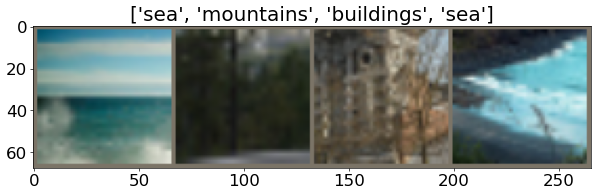

In [3]:
# 화면에 출력되는 이미지 크기를 적절하게 조절하기
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 60
plt.rcParams.update({'font.size': 20})


def imshow(image, title):
    # torch.Tensor => numpy 변환하기
    image = image.numpy().transpose((1, 2, 0))
    # 이미지 정규화(normalization) 해제하기
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    image = np.clip(image, 0, 1)
    # 화면에 이미지 출력하기
    plt.imshow(image)
    plt.title(title)
    plt.show()


# 학습 데이터셋에서 하나의 배치를 불러와 보기
iterator = iter(train_dataloader)

# 현재 배치에 포함된 이미지를 출력하기
inputs, classes = next(iterator)
out = torchvision.utils.make_grid(inputs[:4])
imshow(out, title=[class_names[x] for x in classes[:4]])

#### <b>Problem 2. Convolution 연산 이해하기</b>

* Convolution 연산의 동작 원리를 이해할 필요가 있습니다.
* <b>[그림 예시]</b> 아래 그림에서는 stride가 1이고, padding이 0일 때의 Convolution 연산 예시를 보입니다.

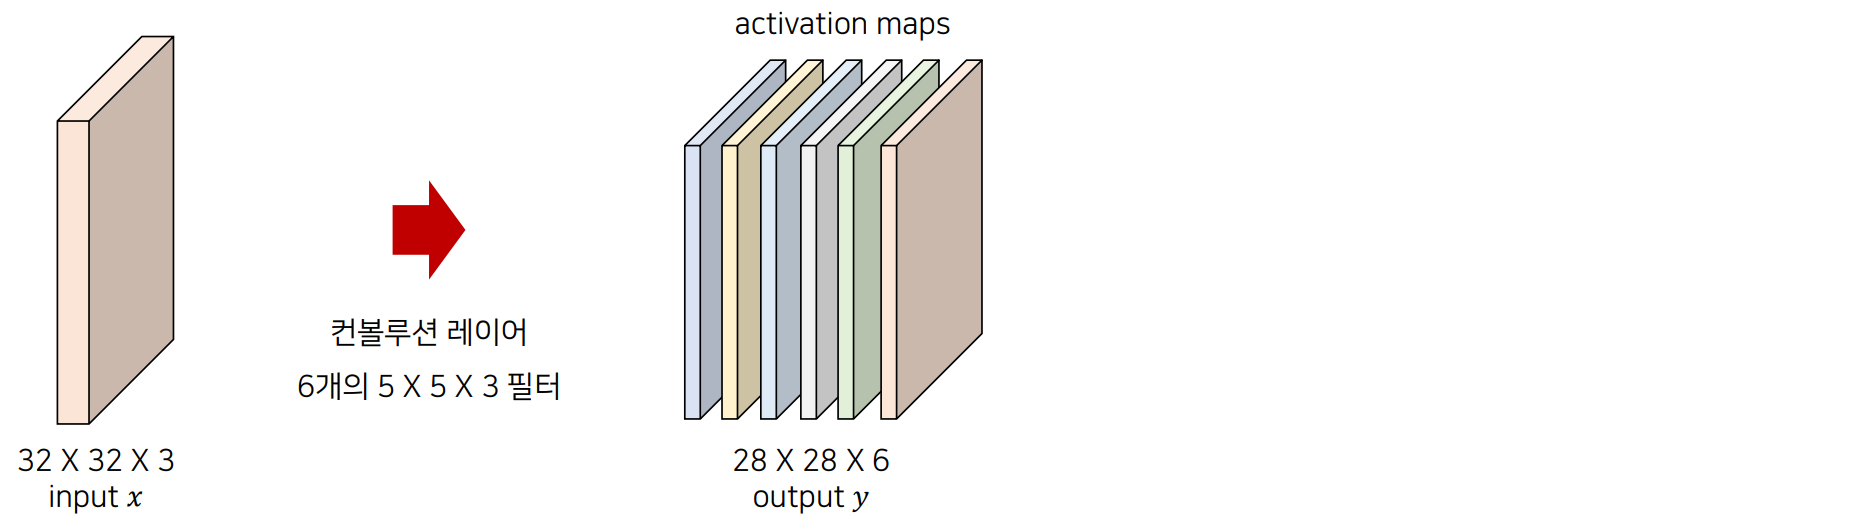

<hr>

* 입력 데이터의 높이: $height$
* 입력 데이터의 너비: $width$
* 필터의 높이: $filter\_height$
* 필터의 너비: $filter\_width$
* 스트라이드(stride): $stride$
* 패딩 크기: $padding$

<hr>

* Convolution 연산 이후의 출력 차원은 다음과 같은 공식으로 계산할 수 있습니다. (나누기할 때 소수점 아래 버림)
    * 출력 높이(output height) = $(height + 2 * padding - filter_{height}) / stride + 1$
    * 출력 너비(output width) = $(width + 2 * padding - filter_{width}) / stride + 1$

* <b>[문제]</b> 다음의 각 경우에 대하여 Convolution 연산을 수행한 뒤의 출력 차원을 쓰세요.
    1. $height=32$, $width=32$, $filter_{height}=5$, $filter_{width}=5$, $stride=2$, $padding=2$일 때 → {(16,16)}
    2. $height=64$, $width=64$, $filter_{height}=3$, $filter_{width}=3$, $stride=1$, $padding=1$일 때 → {(64,64)}
    3. $height=16$, $width=16$, $filter_{height}=4$, $filter_{width}=4$, $stride=2$, $padding=1$일 때 → {(8,8)}
    4. $height=60$, $width=45$, $filter_{height}=8$, $filter_{width}=5$, $stride=3$, $padding=1$일 때 → {(19,15)}

* (Hint) 다음과 같은 Python 코드를 사용하여 간단히 계산할 수 있습니다.

<pre>
height = 16
width = 16
filter_height = 4
filter_width = 4
stride = 2
padding = 1

output_height = (height + 2 * padding - filter_height) // stride + 1
output_width = (width + 2 * padding - filter_width) // stride + 1

print('출력 높이:', output_height, '출력 너비:', output_width)
</pre>

* 실행 결과 예시

<pre>
출력 높이: 8 출력 너비: 8
</pre>

In [4]:
def Output_Dim(height, width, filter_height, filter_width, stride, padding):
    output_height = (height + 2 * padding - filter_height) // stride + 1
    output_width = (width + 2 * padding - filter_width) // stride + 1
    return output_height, output_width

print("출력 높이 : %d, 출력 너비 : %d"%(Output_Dim(32,32,5,5,2,2)))
print("출력 높이 : %d, 출력 너비 : %d"%(Output_Dim(64,64,3,3,1,1)))
print("출력 높이 : %d, 출력 너비 : %d"%(Output_Dim(16,16,4,4,2,1)))
print("출력 높이 : %d, 출력 너비 : %d"%(Output_Dim(60,45,8,5,3,1)))

출력 높이 : 16, 출력 너비 : 16
출력 높이 : 64, 출력 너비 : 64
출력 높이 : 8, 출력 너비 : 8
출력 높이 : 19, 출력 너비 : 15


#### <b>(알아보기) Lenet 아키텍처 이해하기</b>

* 기본적인 LeNet 아키텍처를 이해할 수 있습니다.
    * Convolutional Neural Network를 최초로(1998년) 적용한 간단한 아키텍처입니다.
    * Convolution 연산과 Pooling 연산이 사용됩니다.
* <b>아래의 표</b>와 같은 아키텍처를 PyTorch로 구현한 것을 확인해 봅시다.
    * 원본 논문과 완전히 동일하지는 않지만, 핵심 아이디어를 잘 표현한 아키텍처입니다.
    * PyTorch에서는 모델에 별도로 Softmax 레이어를 두지 않고, 학습할 때 nn.CrossEntropyLoss()를 사용하는 것이 일반적입니다.

Layer | Type | Specification
:-: | :-: | ---
1 | Input | image size: 3 X 64 X 64
2 | Convolution | # of kernel: 20, kernel size: 5 X 5, stride: 1, zero padding: 0
3 | Pooling | max pooling, kernel size: 2 X 2, stride: 2
4 | Convolution | # of kernel: 50, kernel size: 5 X 5, stride: 1, zero padding: 0
5 | Pooling | max pooling, kernel size: 2 X 2, stride: 2
6 | Fully Connected | # of neuron: 500
7 | Activation | ReLU
8 | Fully Connected | # of neuron: 6
9 | Softmax | 6 classes



In [5]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        # → 차원(dimension): (3 x 64 x 64)
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=20, kernel_size=5, stride=1, padding=0)
        # → 차원(dimension): (20 x 60 x 60)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        # → 차원(dimension): (20 x 30 x 30)
        self.conv2 = nn.Conv2d(in_channels=20, out_channels=50, kernel_size=5, stride=1, padding=0)
        # → 차원(dimension): (50 x 26 x 26)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        # → 차원(dimension): (50 x 13 x 13)
        self.fc1 = nn.Linear(50 * 13 * 13, 500)
        # → 차원(dimension): (500)
        self.fc2 = nn.Linear(500, 6)
        # → 차원(dimension): (6)

    def forward(self, x):
        x = self.pool1(self.conv1(x))
        x = self.pool2(self.conv2(x))
        x = torch.flatten(x, 1) # 배치(batch)를 제외한 모든 차원 flatten하기
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

#### <b>(알아보기) 학습 및 평가 함수 이해하기</b>

* 별도의 학습(train) 함수와 평가(validate) 함수를 작성합니다.

In [6]:
def train(net, epoch, optimizer, criterion, train_dataloader):
    print('[ Train epoch: %d ]' % epoch)
    net.train() # 모델을 학습 모드로 설정
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(train_dataloader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad() # 기울기(gradient) 초기화

        outputs = net(inputs) # 모델 입력하여 결과 계산
        loss = criterion(outputs, targets) # 손실(loss) 값 계산
        loss.backward() # 역전파를 통해 기울기(gradient) 계산

        optimizer.step() # 계산된 기울기를 이용해 모델 가중치 업데이트
        train_loss += loss.item()
        _, predicted = outputs.max(1)

        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

    print('Train accuarcy:', 100. * correct / total)
    print('Train average loss:', train_loss / total)
    return (100. * correct / total, train_loss / total)


def validate(net, epoch, val_dataloader):
    print('[ Validation epoch: %d ]' % epoch)
    net.eval() # 모델을 평가 모드로 설정
    val_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(val_dataloader):
        inputs, targets = inputs.to(device), targets.to(device)

        outputs = net(inputs) # 모델 입력하여 결과 계산
        val_loss += criterion(outputs, targets).item()
        _, predicted = outputs.max(1)

        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

    print('Accuarcy:', 100. * correct / total)
    print('Average loss:', val_loss / total)
    return (100. * correct / total, val_loss / total)

#### <b>(알아보기) LeNet 학습하기</b>

* 앞서 정의한 LeNet 네트워크를 학습합니다.
* 학습률(learning rate)을 수정해보면서 결과를 확인해 봅시다.
    * 만약 학습률이 너무 크다면, 발산하여 손실(loss) 값이 NaN으로 나오며 학습이 안 될 수 있습니다.

In [7]:
#learning rate : 0.1~0.007: NaN 나옴(0.006부터 가능)
epoch = 30
List_LR = [5e-3, 4e-3, 3e-3, 2e-3, 1e-3, 9e-4, 8e-4, 7e-4, 6e-4, 5e-4]
List_LR_name = [str(i).replace("-","_").replace(".","_") for i in List_LR]
print(List_LR_name)
Train_acc = np.zeros((epoch,len(List_LR)))
Train_loss = np.zeros((epoch,len(List_LR)))
Val_acc = np.zeros((epoch,len(List_LR)))
Val_loss = np.zeros((epoch,len(List_LR)))
for l,learning_rate in enumerate(List_LR):
    net = LeNet()
    net = net.to(device)
    lr_name =List_LR_name[l]
    file_name = "LeNet_"+lr_name+".pt"
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9, weight_decay=0.0002)
    start_time = time.time() # 시작 시간
    for i in range(epoch):
        train_acc, train_loss = train(net, i, optimizer, criterion, train_dataloader) # 학습(training)
        val_acc, val_loss = validate(net, i + 1, val_dataloader) # 검증(validation)
        # 학습된 모델 저장하기
        state = {
            'net': net.state_dict()
        }
        path_checkpoint = os.path.join(path,'checkpoint')
        if not os.path.isdir(path_checkpoint):
            os.mkdir(path_checkpoint)
            
        torch.save(state, os.path.join(path_checkpoint,file_name))
        print(f'Model saved! (time elapsed: {time.time() - start_time})')
        # 현재 epoch에서의 정확도(accuracy)와 손실(loss) 값 저장하기
        Train_acc[i,l]=train_acc
        Train_loss[i,l]=train_loss
        Val_acc[i,l]=val_acc
        Val_loss[i,l]=val_loss

['0_005', '0_004', '0_003', '0_002', '0_001', '0_0009', '0_0008', '0_0007', '0_0006', '0_0005']
[ Train epoch: 0 ]
Train accuarcy: 51.56674249651427
Train average loss: 0.0388849916072867
[ Validation epoch: 1 ]
Accuarcy: 64.36747872028177
Average loss: 0.03075976684221537
Model saved! (time elapsed: 42.17099976539612)
[ Train epoch: 1 ]
Train accuarcy: 57.75299038673222
Train average loss: 0.034477166391358546
[ Validation epoch: 2 ]
Accuarcy: 69.79747578514822
Average loss: 0.027471345892252023
Model saved! (time elapsed: 49.0612416267395)
[ Train epoch: 2 ]
Train accuarcy: 60.3948044323769
Train average loss: 0.03284747188786046
[ Validation epoch: 3 ]
Accuarcy: 69.62136777223364
Average loss: 0.026760970370525272
Model saved! (time elapsed: 55.53468418121338)
[ Train epoch: 3 ]
Train accuarcy: 61.59829749761503
Train average loss: 0.03209852231452529
[ Validation epoch: 4 ]
Accuarcy: 72.11623128852362
Average loss: 0.024780081519990994
Model saved! (time elapsed: 62.06845498085022)

Accuarcy: 73.14352803052539
Average loss: 0.024755213454492567
Model saved! (time elapsed: 39.44313430786133)
[ Train epoch: 6 ]
Train accuarcy: 66.31687091803038
Train average loss: 0.028359295682913403
[ Validation epoch: 7 ]
Accuarcy: 73.75990607572645
Average loss: 0.024662695236838665
Model saved! (time elapsed: 46.021244525909424)
[ Train epoch: 7 ]
Train accuarcy: 66.25082556688926
Train average loss: 0.028752573462709027
[ Validation epoch: 8 ]
Accuarcy: 75.05136483710008
Average loss: 0.022153609845867107
Model saved! (time elapsed: 52.596232175827026)
[ Train epoch: 8 ]
Train accuarcy: 66.14808835400308
Train average loss: 0.028487478227129666
[ Validation epoch: 9 ]
Accuarcy: 76.34282359847373
Average loss: 0.022462729321990085
Model saved! (time elapsed: 59.104933738708496)
[ Train epoch: 9 ]
Train accuarcy: 67.76986864313496
Train average loss: 0.027779583357273985
[ Validation epoch: 10 ]
Accuarcy: 74.17082477252715
Average loss: 0.022941178578521487
Model saved! (time el

Accuarcy: 75.43293219841503
Average loss: 0.021705485672624644
Model saved! (time elapsed: 78.20699381828308)
[ Train epoch: 12 ]
Train accuarcy: 69.2668966023336
Train average loss: 0.026411968327027
[ Validation epoch: 13 ]
Accuarcy: 72.29233930143822
Average loss: 0.024742446286537656
Model saved! (time elapsed: 84.60359787940979)
[ Train epoch: 13 ]
Train accuarcy: 69.89799662434872
Train average loss: 0.026016597880510223
[ Validation epoch: 14 ]
Accuarcy: 75.2861755209862
Average loss: 0.022550109862441502
Model saved! (time elapsed: 91.176114320755)
[ Train epoch: 14 ]
Train accuarcy: 70.13282453951713
Train average loss: 0.025542074009757526
[ Validation epoch: 15 ]
Accuarcy: 77.45817434693278
Average loss: 0.021441215796312488
Model saved! (time elapsed: 97.77428770065308)
[ Train epoch: 15 ]
Train accuarcy: 69.80259778381155
Train average loss: 0.02572015765268437
[ Validation epoch: 16 ]
Accuarcy: 78.6028764308776
Average loss: 0.019883441835825556
Model saved! (time elapsed

Accuarcy: 75.49163486938656
Average loss: 0.02172087849778516
Model saved! (time elapsed: 117.66685342788696)
[ Train epoch: 18 ]
Train accuarcy: 72.15821530784471
Train average loss: 0.024212535248469683
[ Validation epoch: 19 ]
Accuarcy: 77.42882301144702
Average loss: 0.020406589270652756
Model saved! (time elapsed: 124.15583848953247)
[ Train epoch: 19 ]
Train accuarcy: 72.59117927643649
Train average loss: 0.023640212363504633
[ Validation epoch: 20 ]
Accuarcy: 78.54417375990607
Average loss: 0.019461044327128762
Model saved! (time elapsed: 130.6996786594391)
[ Train epoch: 20 ]
Train accuarcy: 71.99677111616643
Train average loss: 0.024104602970065343
[ Validation epoch: 21 ]
Accuarcy: 78.30936307601996
Average loss: 0.01971527722387815
Model saved! (time elapsed: 137.1828441619873)
[ Train epoch: 21 ]
Train accuarcy: 72.30498275482498
Train average loss: 0.023683514151594528
[ Validation epoch: 22 ]
Accuarcy: 77.6049310243616
Average loss: 0.020168292800597093
Model saved! (time

Accuarcy: 78.1919577340769
Average loss: 0.019964825811363714
Model saved! (time elapsed: 158.57424545288086)
[ Train epoch: 24 ]
Train accuarcy: 72.75262346811478
Train average loss: 0.023341700748520027
[ Validation epoch: 25 ]
Accuarcy: 78.30936307601996
Average loss: 0.020027408763954358
Model saved! (time elapsed: 165.17421984672546)
[ Train epoch: 25 ]
Train accuarcy: 73.30300139429075
Train average loss: 0.023126824945594135
[ Validation epoch: 26 ]
Accuarcy: 80.51071323745231
Average loss: 0.018179233949975882
Model saved! (time elapsed: 171.73923897743225)
[ Train epoch: 26 ]
Train accuarcy: 73.43509209657299
Train average loss: 0.022948863151672345
[ Validation epoch: 27 ]
Accuarcy: 79.16055180510713
Average loss: 0.01899771052072361
Model saved! (time elapsed: 178.33370351791382)
[ Train epoch: 27 ]
Train accuarcy: 73.12688045791444
Train average loss: 0.02293954878102887
[ Validation epoch: 28 ]
Accuarcy: 79.07249779864983
Average loss: 0.019108485285053864
Model saved! (ti

Accuarcy: 78.89638978573525
Average loss: 0.018914229583978162
Model saved! (time elapsed: 196.73567748069763)
[ Train epoch: 0 ]
Train accuarcy: 47.332501651133775
Train average loss: 0.042143503616375276
[ Validation epoch: 1 ]
Accuarcy: 60.46375110067508
Average loss: 0.0344418992141072
Model saved! (time elapsed: 6.621165752410889)
[ Train epoch: 1 ]
Train accuarcy: 56.38805312981581
Train average loss: 0.03590456420015657
[ Validation epoch: 2 ]
Accuarcy: 64.51423539771059
Average loss: 0.031184630132260336
Model saved! (time elapsed: 13.083294153213501)
[ Train epoch: 2 ]
Train accuarcy: 58.87576135613121
Train average loss: 0.033591180053470754
[ Validation epoch: 3 ]
Accuarcy: 68.41796301731729
Average loss: 0.02726718787752291
Model saved! (time elapsed: 19.686980485916138)
[ Train epoch: 3 ]
Train accuarcy: 61.39282307184266
Train average loss: 0.03196377119804904
[ Validation epoch: 4 ]
Accuarcy: 71.41179923686528
Average loss: 0.025518164489148194
Model saved! (time elapsed

Accuarcy: 72.20428529498092
Average loss: 0.02448864343721285
Model saved! (time elapsed: 39.52674436569214)
[ Train epoch: 6 ]
Train accuarcy: 63.8952080428561
Train average loss: 0.030005083206491267
[ Validation epoch: 7 ]
Accuarcy: 72.0575286175521
Average loss: 0.024966441661268168
Model saved! (time elapsed: 46.09606862068176)
[ Train epoch: 7 ]
Train accuarcy: 64.73912086299259
Train average loss: 0.02902820483511644
[ Validation epoch: 8 ]
Accuarcy: 73.9653654241268
Average loss: 0.023265938955491193
Model saved! (time elapsed: 52.66975426673889)
[ Train epoch: 8 ]
Train accuarcy: 65.62706391722315
Train average loss: 0.028696860803969583
[ Validation epoch: 9 ]
Accuarcy: 74.90460815967127
Average loss: 0.022265484317642942
Model saved! (time elapsed: 59.26182985305786)
[ Train epoch: 9 ]
Train accuarcy: 66.25082556688926
Train average loss: 0.02796329731653238
[ Validation epoch: 10 ]
Accuarcy: 75.40358086292926
Average loss: 0.021910700939392323
Model saved! (time elapsed: 65

Accuarcy: 71.08893454652187
Average loss: 0.024092114633012106
Model saved! (time elapsed: 79.50778031349182)
[ Train epoch: 12 ]
Train accuarcy: 67.09473838702576
Train average loss: 0.02740102601985619
[ Validation epoch: 13 ]
Accuarcy: 74.22952744349868
Average loss: 0.022639243850128582
Model saved! (time elapsed: 86.09229850769043)
[ Train epoch: 13 ]
Train accuarcy: 67.82123724957805
Train average loss: 0.027105463026134514
[ Validation epoch: 14 ]
Accuarcy: 73.6425007337834
Average loss: 0.0228868924892645
Model saved! (time elapsed: 92.7682695388794)
[ Train epoch: 14 ]
Train accuarcy: 68.52572099508329
Train average loss: 0.026642870560092693
[ Validation epoch: 15 ]
Accuarcy: 76.25476959201643
Average loss: 0.0212392861065642
Model saved! (time elapsed: 99.32915997505188)
[ Train epoch: 15 ]
Train accuarcy: 68.00469655830337
Train average loss: 0.02653478736738173
[ Validation epoch: 16 ]
Accuarcy: 74.37628412092751
Average loss: 0.022252273115203426
Model saved! (time elapse

Accuarcy: 74.14147343704138
Average loss: 0.02233272631706504
Model saved! (time elapsed: 116.20463562011719)
[ Train epoch: 18 ]
Train accuarcy: 68.84860937843986
Train average loss: 0.026079110277978903
[ Validation epoch: 19 ]
Accuarcy: 74.9633108306428
Average loss: 0.022095105516480182
Model saved! (time elapsed: 122.61493372917175)
[ Train epoch: 19 ]
Train accuarcy: 69.7732442944155
Train average loss: 0.02578819607475879
[ Validation epoch: 20 ]
Accuarcy: 75.96125623715879
Average loss: 0.021299583535058637
Model saved! (time elapsed: 129.057555437088)
[ Train epoch: 20 ]
Train accuarcy: 70.21354663535628
Train average loss: 0.025155079726069902
[ Validation epoch: 21 ]
Accuarcy: 76.01995890813032
Average loss: 0.02113962426261185
Model saved! (time elapsed: 135.37212228775024)
[ Train epoch: 21 ]
Train accuarcy: 70.30894547589345
Train average loss: 0.02520098710800202
[ Validation epoch: 22 ]
Accuarcy: 76.75374229527444
Average loss: 0.02052883378284433
Model saved! (time ela

[68.54039774 71.1528583  72.77463859 73.97079328 73.97813165 73.53049094
 73.33969326 73.62588978 72.68657812 72.73794672]
[77.13530966 78.72028177 79.42471382 80.80422659 80.51071324 79.16055181
 78.95509246 79.71822718 79.04314646 78.74963311]


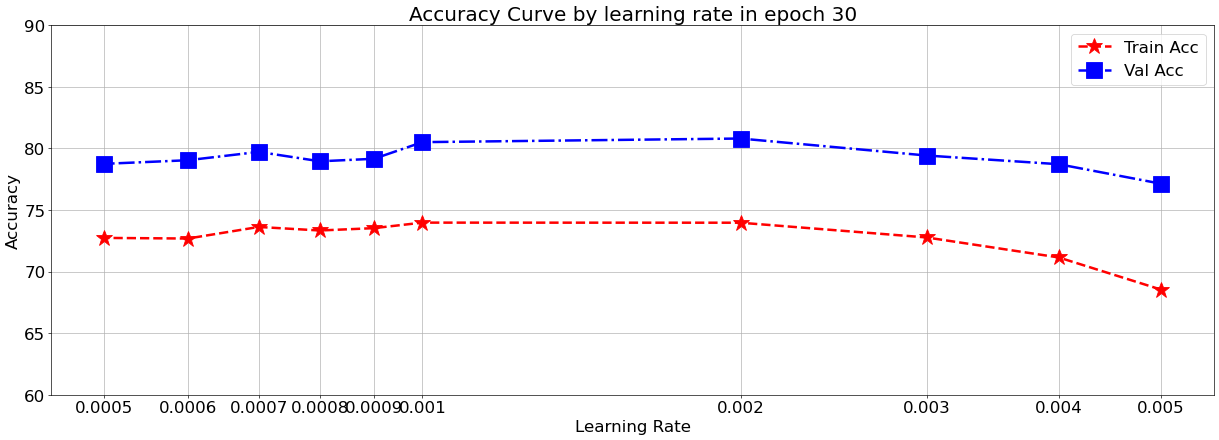

In [17]:
Train_max_acc = np.max(Train_acc,axis = 0)
Val_max_acc = np.max(Val_acc,axis = 0)
print(Train_max_acc)
print(Val_max_acc)
plt.figure(figsize=(25,8))
plt.plot(List_LR, Train_max_acc,'r*--',markersize=20,linewidth=3, label = "Train Acc")
plt.plot(List_LR, Val_max_acc,'bs-.',markersize=20,linewidth=3, label = "Val Acc")
# plt.xlim(1e-6,5e-3)
plt.ylim(60,90)
plt.xlabel("Learning Rate")
plt.ylabel("Accuracy")
plt.semilogx(base=10)
plt.xticks(List_LR,List_LR)
plt.title("Accuracy Curve by learning rate in epoch 30")
plt.legend()
plt.grid()
plt.show()

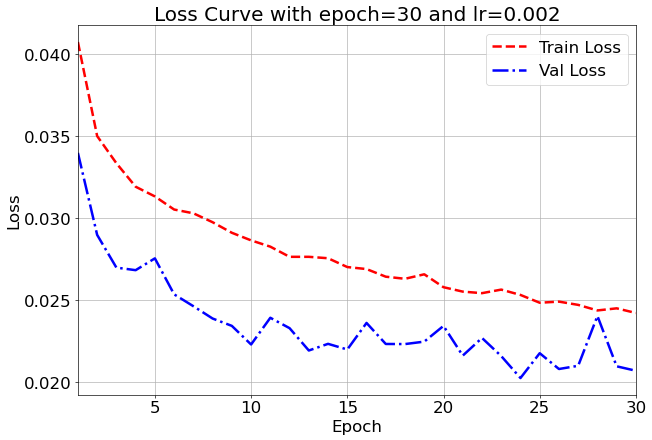

In [59]:
# List_LR 중 0.002 값일 때의 Val 정확성이 가장 높았으므로 이때의 Loss 값을 확인한다.
Train_max_loss = Train_loss[:,3]
Val_max_loss = Val_loss[:,3]
x = np.linspace(1,30,30)
plt.figure()
plt.plot(x,Train_max_loss,'r--',linewidth=3,label="Train Loss")
plt.plot(x,Val_max_loss,'b-.',linewidth=3,label="Val Loss")
plt.xlim(1,30)
plt.title("Loss Curve with epoch=30 and lr=0.002")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.show()

#### <b>(알아보기) 혼동 행렬 시각화하기</b>

* 참고: [Seaborn.heatmap 공식 문서](https://seaborn.pydata.org/generated/seaborn.heatmap.html) 
* 각 클래스에 대하여 정확히 분류하는지 확인하기 위해 <b>혼동 행렬(confusion matrix)</b>을 생성할 수 있습니다.

In [7]:
# 네트워크에 데이터셋을 입력하여 혼동 행렬(confusion matrix)을 계산하는 함수
def get_confusion_matrix(net, num_classes, data_loader):
    net.eval() # 모델을 평가 모드로 설정
    confusion_matrix = torch.zeros(num_classes, num_classes, dtype=torch.int32)

    for batch_idx, (inputs, targets) in enumerate(data_loader):
        inputs, targets = inputs.to(device), targets.to(device)

        outputs = net(inputs)
        _, predicted = outputs.max(1)

        for t, p in zip(targets.view(-1), predicted.view(-1)):
            confusion_matrix[t.long(), p.long()] += 1

    return confusion_matrix

[ 각 클래스당 데이터 개수 ]
tensor([523, 540, 594, 599, 560, 591])
[ 혼동 행렬(confusion matrix) 시각화 ]


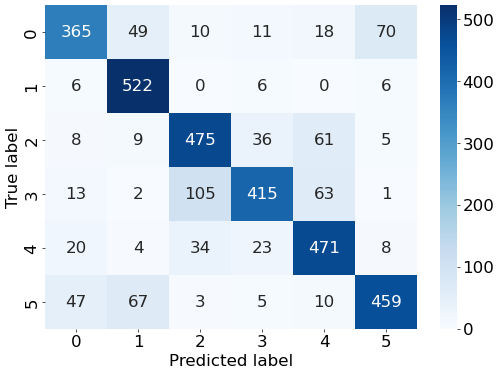

[ 각 클래스에 따른 정확도 ]
tensor([0.6979, 0.9667, 0.7997, 0.6928, 0.8411, 0.7766])
[ 전체 평균 정확도 ]
tensor(0.7945)


In [15]:
net = LeNet()
net = net.to(device)

file_name = "LeNet_0_002.pt"
file = os.path.join(path_checkpoint,file_name)
checkpoint = torch.load(file)
net.load_state_dict(checkpoint['net'])

# 평가 데이터셋을 이용해 혼동 행렬(confusion matrix) 계산하기
confusion_matrix = get_confusion_matrix(net, 6, val_dataloader)
print("[ 각 클래스당 데이터 개수 ]")
print(confusion_matrix.sum(1))

print("[ 혼동 행렬(confusion matrix) 시각화 ]")
res = pd.DataFrame(confusion_matrix.numpy(), index = [i for i in range(6)], columns = [i for i in range(6)])
res.index.name = 'True label'
res.columns.name = 'Predicted label'
plt.figure(figsize = (10, 7))
sns.heatmap(res, annot=True, fmt="d", cmap='Blues')
plt.show()

print("[ 각 클래스에 따른 정확도 ]")
# (각 클래스마다 정답 개수 / 각 클래스마다 데이터의 개수)
print(confusion_matrix.diag() / confusion_matrix.sum(1))

print("[ 전체 평균 정확도 ]")
print(confusion_matrix.diag().sum() / confusion_matrix.sum())

#### <b>Problem 3. CustomLeNet 아키텍처 작성하기</b>

* 다음과 같이 LeNet 아키텍처를 변경하여 CustomLeNet을 만들어 봅시다.
    * 커널 크기와 커널의 개수를 증가시켰습니다. (파라미터 수 증가)
    * Fully Connected 레이어의 차원을 증가시켰습니다. (파라미터 수 증가)

Layer | Type | Input dimension | Specification
:-: | :-: | :-: | ---
1 | Input | - | image size: 3 X 64 X 64
2 | Convolution | 3 X 64 X 64 | # of kernel: 128, kernel size: 8 X 8, stride: 1, zero padding: 0
3 | Pooling | 128 x 57 x 57 | max pooling, kernel size: 2 X 2, stride: 2
4 | Convolution | 128 x 28 x 28 | # of kernel: 256, kernel size: 8 X 8, stride: 1, zero padding: 0
5 | Pooling | 256 x 21 x 21 | max pooling, kernel size: 2 X 2, stride: 2
6 | Convolution | 256 x 10 x 10 | # of kernel: 512, kernel size: 4 X 4, stride: 1, zero padding: 0
7 | Pooling | 512 x 7 x 7 | max pooling, kernel size: 2 X 2, stride: 2
8 | Fully Connected | 512 x 3 x 3 | # of neuron: 4096
9 | Activation | 4096 | ReLU
10 | Fully Connected | 4096 | # of neuron: 6
11 | Softmax | 6 | 6 classes


In [18]:
class CustomLeNet(nn.Module):
    def __init__(self):
        super(CustomLeNet, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=128, kernel_size=8, stride=1, padding=0)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=8, stride=1, padding=0)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv3 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=4, stride=1, padding=0)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(512 * 3 * 3, 4096)
        self.fc2 = nn.Linear(4096, 6)
        
    def forward(self, x):
        x = self.pool1(self.conv1(x))
        x = self.pool2(self.conv2(x))
        x = self.pool3(self.conv3(x))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

#### <b>(알아보기) CustomLeNet 평가하기</b>

* 새롭게 작성한 CustomLeNet과 앞선 LeNet의 성능을 비교합니다.
    * 파라미터가 증가한 만큼 성능 향상이 있는지 확인해 봅시다.
* 아래 코드를 실행하여 학습 및 성능 평가를 진행할 수 있습니다.

In [19]:
epoch = 30
Train_acc = np.zeros((epoch,len(List_LR)))
Train_loss = np.zeros((epoch,len(List_LR)))
Val_acc = np.zeros((epoch,len(List_LR)))
Val_loss = np.zeros((epoch,len(List_LR)))

for l,learning_rate in enumerate(List_LR):
    lr_name = List_LR_name[l]
    file_name = "CustomLeNet_"+lr_name+".pt"

    net = CustomLeNet()
    net = net.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9, weight_decay=0.0002)
    start_time = time.time() # 시작 시간

    for i in range(epoch):
        train_acc, train_loss = train(net, i, optimizer, criterion, train_dataloader) # 학습(training)
        val_acc, val_loss = validate(net, i + 1, val_dataloader) # 검증(validation)

        # 학습된 모델 저장하기
        state = {
            'net': net.state_dict()
        }
        
        path_checkpoint = os.path.join(path,'checkpoint')
        if not os.path.isdir(path_checkpoint):
            os.mkdir(path_checkpoint)
            
        torch.save(state, os.path.join(path_checkpoint, file_name))
        print(f'Model saved! (time elapsed: {time.time() - start_time})')
        # 현재 epoch에서의 정확도(accuracy)와 손실(loss) 값 저장하기
        Train_acc[i,l]=train_acc
        Train_loss[i,l]=train_loss
        Val_acc[i,l]=val_acc
        Val_loss[i,l]=val_loss

[ Train epoch: 0 ]
Train accuarcy: 48.29382842885448
Train average loss: 0.040539221992983966
[ Validation epoch: 1 ]
Accuarcy: 57.49926621661285
Average loss: 0.03427945097975623
Model saved! (time elapsed: 9.816843032836914)
[ Train epoch: 1 ]
Train accuarcy: 55.206575181624714
Train average loss: 0.03610805807035265
[ Validation epoch: 2 ]
Accuarcy: 56.97094217786909
Average loss: 0.03422906568822253
Model saved! (time elapsed: 19.498632192611694)
[ Train epoch: 2 ]
Train accuarcy: 56.79900198136053
Train average loss: 0.03501241012654284
[ Validation epoch: 3 ]
Accuarcy: 66.12855884942765
Average loss: 0.029146664069830443
Model saved! (time elapsed: 29.230992078781128)
[ Train epoch: 3 ]
Train accuarcy: 58.97849856901739
Train average loss: 0.03404464269494454
[ Validation epoch: 4 ]
Accuarcy: 62.811857939536246
Average loss: 0.03036958948411933
Model saved! (time elapsed: 38.93732237815857)
[ Train epoch: 4 ]
Train accuarcy: 59.68298231452264
Train average loss: 0.033488362526748

Train accuarcy: 62.222059147281136
Train average loss: 0.03129381981530752
[ Validation epoch: 7 ]
Accuarcy: 71.70531259172293
Average loss: 0.024954029899347484
Model saved! (time elapsed: 68.39439582824707)
[ Train epoch: 7 ]
Train accuarcy: 62.55962427533573
Train average loss: 0.031049882319367728
[ Validation epoch: 8 ]
Accuarcy: 65.0132081009686
Average loss: 0.028843272194191968
Model saved! (time elapsed: 78.1525948047638)
[ Train epoch: 8 ]
Train accuarcy: 63.23475453144493
Train average loss: 0.030785449796721286
[ Validation epoch: 9 ]
Accuarcy: 70.38450249486351
Average loss: 0.025846100952186507
Model saved! (time elapsed: 87.83473467826843)
[ Train epoch: 9 ]
Train accuarcy: 64.31349526674984
Train average loss: 0.030119719445910992
[ Validation epoch: 10 ]
Accuarcy: 64.71969474611095
Average loss: 0.03126176317871089
Model saved! (time elapsed: 97.35896420478821)
[ Train epoch: 10 ]
Train accuarcy: 62.8238056799002
Train average loss: 0.03072630556688066
[ Validation epo

Train accuarcy: 66.74249651427313
Train average loss: 0.02831750323253323
[ Validation epoch: 13 ]
Accuarcy: 71.61725858526563
Average loss: 0.023619157943622016
Model saved! (time elapsed: 124.09588885307312)
[ Train epoch: 13 ]
Train accuarcy: 65.83987671534453
Train average loss: 0.028935180867226552
[ Validation epoch: 14 ]
Accuarcy: 74.11212210155563
Average loss: 0.02413751660360421
Model saved! (time elapsed: 133.83464336395264)
[ Train epoch: 14 ]
Train accuarcy: 66.85991047185735
Train average loss: 0.028039797131222833
[ Validation epoch: 15 ]
Accuarcy: 72.58585265629586
Average loss: 0.025213795128825964
Model saved! (time elapsed: 143.56583333015442)
[ Train epoch: 15 ]
Train accuarcy: 67.02869303588464
Train average loss: 0.027974878625421154
[ Validation epoch: 16 ]
Accuarcy: 71.61725858526563
Average loss: 0.025794521153480524
Model saved! (time elapsed: 153.34980058670044)
[ Train epoch: 16 ]
Train accuarcy: 66.93329419534747
Train average loss: 0.02791624507664707
[ Va

Train accuarcy: 68.56241285682836
Train average loss: 0.02657099679979582
[ Validation epoch: 19 ]
Accuarcy: 73.90666275315527
Average loss: 0.022461003761400672
Model saved! (time elapsed: 183.45007848739624)
[ Train epoch: 19 ]
Train accuarcy: 69.75122917736846
Train average loss: 0.02578325894071918
[ Validation epoch: 20 ]
Accuarcy: 73.14352803052539
Average loss: 0.02342118640816523
Model saved! (time elapsed: 193.19521570205688)
[ Train epoch: 20 ]
Train accuarcy: 69.8833198796507
Train average loss: 0.025514317248181987
[ Validation epoch: 21 ]
Accuarcy: 75.60904021132961
Average loss: 0.02160567207913053
Model saved! (time elapsed: 202.92972564697266)
[ Train epoch: 21 ]
Train accuarcy: 69.52373963454906
Train average loss: 0.02541961578155129
[ Validation epoch: 22 ]
Accuarcy: 75.3742295274435
Average loss: 0.022685613184686208
Model saved! (time elapsed: 212.66697359085083)
[ Train epoch: 22 ]
Train accuarcy: 69.86130476260365
Train average loss: 0.0256367839947742
[ Validati

Train accuarcy: 70.41168268877963
Train average loss: 0.025028140089819278
[ Validation epoch: 25 ]
Accuarcy: 77.1940123275609
Average loss: 0.020442381925445726
Model saved! (time elapsed: 244.38043975830078)
[ Train epoch: 25 ]
Train accuarcy: 70.06677918837602
Train average loss: 0.025003898764440438
[ Validation epoch: 26 ]
Accuarcy: 77.04725565013209
Average loss: 0.02051776648442487
Model saved! (time elapsed: 254.09230518341064)
[ Train epoch: 26 ]
Train accuarcy: 70.66852572099508
Train average loss: 0.02452595536423821
[ Validation epoch: 27 ]
Accuarcy: 75.75579688875844
Average loss: 0.02167249713907642
Model saved! (time elapsed: 263.78503465652466)
[ Train epoch: 27 ]
Train accuarcy: 70.38232919938358
Train average loss: 0.02480185183669043
[ Validation epoch: 28 ]
Accuarcy: 76.69503962430291
Average loss: 0.02047732208686243
Model saved! (time elapsed: 273.4599368572235)
[ Train epoch: 28 ]
Train accuarcy: 70.58046525280693
Train average loss: 0.024296459662133077
[ Valida

Train accuarcy: 45.46855507448448
Train average loss: 0.04314760698334018
[ Validation epoch: 1 ]
Accuarcy: 49.985324332257115
Average loss: 0.03843361895071085
Model saved! (time elapsed: 9.67309832572937)
[ Train epoch: 1 ]
Train accuarcy: 53.584794892492845
Train average loss: 0.037496434861044106
[ Validation epoch: 2 ]
Accuarcy: 60.52245377164661
Average loss: 0.032508363061053404
Model saved! (time elapsed: 19.4390652179718)
[ Train epoch: 2 ]
Train accuarcy: 56.38805312981581
Train average loss: 0.03491008801340243
[ Validation epoch: 3 ]
Accuarcy: 66.0111535074846
Average loss: 0.028774481628659816
Model saved! (time elapsed: 29.182610750198364)
[ Train epoch: 3 ]
Train accuarcy: 57.69428340794012
Train average loss: 0.03396744259894266
[ Validation epoch: 4 ]
Accuarcy: 65.21866744936895
Average loss: 0.02911958661742808
Model saved! (time elapsed: 38.95206165313721)
[ Train epoch: 4 ]
Train accuarcy: 59.74902766566375
Train average loss: 0.032720668440809196
[ Validation epoch

Train accuarcy: 61.583620752917
Train average loss: 0.03127947215018465
[ Validation epoch: 7 ]
Accuarcy: 68.6527737012034
Average loss: 0.02609219501576257
Model saved! (time elapsed: 68.69749999046326)
[ Train epoch: 7 ]
Train accuarcy: 62.97057312688046
Train average loss: 0.030448889613387747
[ Validation epoch: 8 ]
Accuarcy: 70.47255650132081
Average loss: 0.025155758486838153
Model saved! (time elapsed: 78.61795496940613)
[ Train epoch: 8 ]
Train accuarcy: 63.403537095472224
Train average loss: 0.030013291512283075
[ Validation epoch: 9 ]
Accuarcy: 72.6445553272674
Average loss: 0.023944074181401907
Model saved! (time elapsed: 88.43615293502808)
[ Train epoch: 9 ]
Train accuarcy: 63.68239524473472
Train average loss: 0.02959899212299811
[ Validation epoch: 10 ]
Accuarcy: 69.29850308189023
Average loss: 0.025549301320519097
Model saved! (time elapsed: 98.2429678440094)
[ Train epoch: 10 ]
Train accuarcy: 64.78315109708667
Train average loss: 0.029233392169192643
[ Validation epoch

Train accuarcy: 65.09136273574521
Train average loss: 0.028718719319183794
[ Validation epoch: 13 ]
Accuarcy: 72.76196066921045
Average loss: 0.023486935815959512
Model saved! (time elapsed: 127.0617983341217)
[ Train epoch: 13 ]
Train accuarcy: 65.4729580978939
Train average loss: 0.02848818300929818
[ Validation epoch: 14 ]
Accuarcy: 72.0575286175521
Average loss: 0.023865683340487467
Model saved! (time elapsed: 136.97151803970337)
[ Train epoch: 14 ]
Train accuarcy: 66.44896162031262
Train average loss: 0.027987826174070262
[ Validation epoch: 15 ]
Accuarcy: 73.49574405635457
Average loss: 0.023053074183966498
Model saved! (time elapsed: 146.72509336471558)
[ Train epoch: 15 ]
Train accuarcy: 66.98466280179056
Train average loss: 0.02765547557806876
[ Validation epoch: 16 ]
Accuarcy: 75.31552685647198
Average loss: 0.0220176427375546
Model saved! (time elapsed: 156.5185568332672)
[ Train epoch: 16 ]
Train accuarcy: 66.71314302487708
Train average loss: 0.027618657414575677
[ Validat

Train accuarcy: 67.13143024877083
Train average loss: 0.02756415020477363
[ Validation epoch: 19 ]
Accuarcy: 74.11212210155563
Average loss: 0.02266709905829568
Model saved! (time elapsed: 186.45535039901733)
[ Train epoch: 19 ]
Train accuarcy: 67.26352095105305
Train average loss: 0.027399814169554032
[ Validation epoch: 20 ]
Accuarcy: 72.6445553272674
Average loss: 0.02368042867555274
Model saved! (time elapsed: 196.39879512786865)
[ Train epoch: 20 ]
Train accuarcy: 67.66713143024877
Train average loss: 0.027051510401532124
[ Validation epoch: 21 ]
Accuarcy: 73.11417669503962
Average loss: 0.022684879795630938
Model saved! (time elapsed: 206.26330161094666)
[ Train epoch: 21 ]
Train accuarcy: 67.97534306890732
Train average loss: 0.026784971348737387
[ Validation epoch: 22 ]
Accuarcy: 74.08277076606986
Average loss: 0.022065868703437963
Model saved! (time elapsed: 216.04137110710144)
[ Train epoch: 22 ]
Train accuarcy: 67.65979305789976
Train average loss: 0.02681998036670048
[ Vali

[65.48029647 67.93131283 69.80259778 71.29228737 71.24825714 71.07947457
 70.71255596 70.50708153 69.80259778 69.92001174]
[76.13736425 76.22541826 76.98855298 77.54622835 77.98649839 78.51482242
 77.60493102 77.252715   77.04725565 77.10595832]


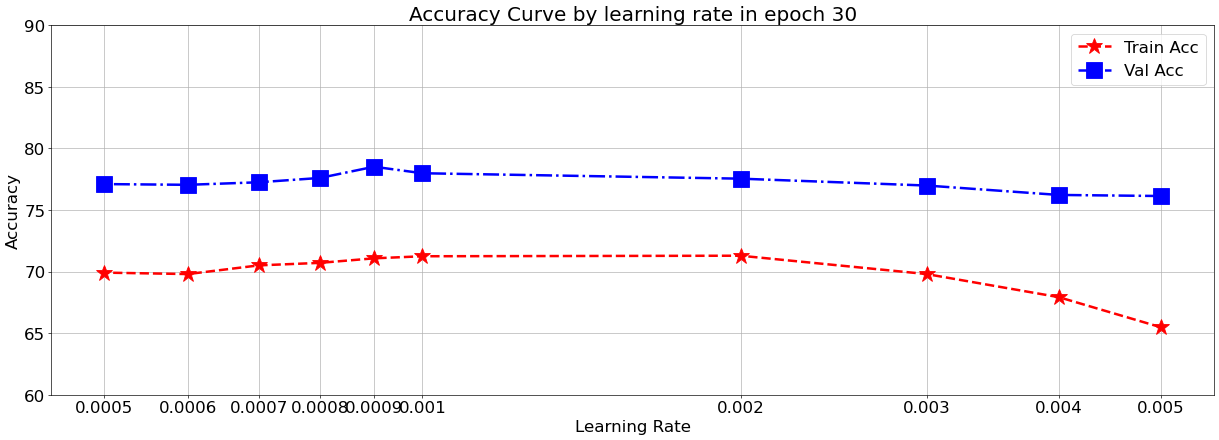

In [60]:
Train_max_acc = np.max(Train_acc,axis = 0)
Val_max_acc = np.max(Val_acc,axis = 0)
print(Train_max_acc)
print(Val_max_acc)
plt.figure(figsize=(25,8))
plt.plot(List_LR, Train_max_acc,'r*--',markersize=20,linewidth=3, label = "Train Acc")
plt.plot(List_LR, Val_max_acc,'bs-.',markersize=20,linewidth=3, label = "Val Acc")
plt.ylim(60,90)
plt.semilogx(base=10)
plt.xticks(List_LR,List_LR)
plt.xlabel("Learning Rate")
plt.ylabel("Accuracy")
plt.title("Accuracy Curve by learning rate in epoch 30")
plt.legend()
plt.grid()
plt.show()

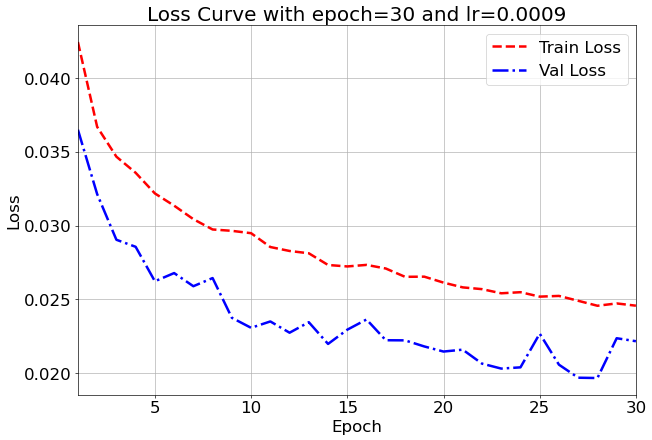

In [61]:
# List_LR 중 0.0009 값일 때의 Val 정확성이 가장 높았으므로 이때의 Loss 값을 확인한다.
Train_max_loss = Train_loss[:,5]
Val_max_loss = Val_loss[:,5]
x = np.linspace(1,30,30)
plt.figure()
plt.plot(x,Train_max_loss,'r--',linewidth=3,label="Train Loss")
plt.plot(x,Val_max_loss,'b-.',linewidth=3,label="Val Loss")
plt.xlim(1,30)
plt.title("Loss Curve with epoch=30 and lr=0.0009")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.show()

[ 각 클래스당 데이터 개수 ]
tensor([523, 540, 594, 599, 560, 591])
[ 혼동 행렬(confusion matrix) 시각화 ]


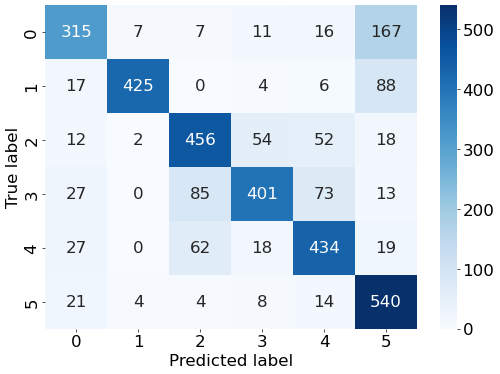

[ 각 클래스에 따른 정확도 ]
tensor([0.6023, 0.7870, 0.7677, 0.6694, 0.7750, 0.9137])
[ 전체 평균 정확도 ]
tensor(0.7546)


In [62]:
net = CustomLeNet()
net = net.to(device)

file_name = "./checkpoint/CustomLeNet_0_0009.pt"
checkpoint = torch.load(file_name)
net.load_state_dict(checkpoint['net'])

# 평가 데이터셋을 이용해 혼동 행렬(confusion matrix) 계산하기
confusion_matrix = get_confusion_matrix(net, 6, val_dataloader)
print("[ 각 클래스당 데이터 개수 ]")
print(confusion_matrix.sum(1))

print("[ 혼동 행렬(confusion matrix) 시각화 ]")
res = pd.DataFrame(confusion_matrix.numpy(), index = [i for i in range(6)], columns = [i for i in range(6)])
res.index.name = 'True label'
res.columns.name = 'Predicted label'
plt.figure(figsize = (10, 7))
sns.heatmap(res, annot=True, fmt="d", cmap='Blues')
plt.show()

print("[ 각 클래스에 따른 정확도 ]")
# (각 클래스마다 정답 개수 / 각 클래스마다 데이터의 개수)
print(confusion_matrix.diag() / confusion_matrix.sum(1))

print("[ 전체 평균 정확도 ]")
print(confusion_matrix.diag().sum() / confusion_matrix.sum())

#### <b>Problem 4. AlexNet 아키텍처 작성하기</b>

* AlexNet은 CNN 기반의 분류 모델의 우수성을 전 세계에 알린 논문([NIPS 2012](https://papers.nips.cc/paper/2012/file/c399862d3b9d6b76c8436e924a68c45b-Paper.pdf))입니다.
    * ImageNet 분류 대회(ILSVRC 2012)에서 압도적인 성능으로 우승(1위)을 차지했습니다.

<hr>

* LRN (Local Response Normalization)을 활용합니다.
    * PyTorch에서 [nn.LocalResponseNorm()](https://pytorch.org/docs/stable/generated/torch.nn.LocalResponseNorm.html)을 이용해 구현할 수 있습니다.
    * Local Response Normalization은 입력과 출력의 차원이 동일한 레이어입니다.
* Dropout을 활용합니다.
    * PyTorch에서 [nn.Dropout()](https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html)을 이용해 구현할 수 있습니다.
* ReLU를 적극적으로 활용합니다.
    * PyTorch에서 [nn.ReLU()](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html)를 이용해 구현할 수 있습니다.

<hr>

* <b>아래의 표</b>와 같은 아키텍처를 PyTorch로 구현해 봅시다.
    * 원본 논문에서 제안한 것과 완전히 동일한 아키텍처는 아니지만, 핵심 아이디어를 잘 포함하고 있습니다.

Layer | Type | Input dimension | Specification
:-: | :-: | :-: | ---
1 | Input | - | image size: 3 X 64 X 64
2 | Convolution | 3 x 64 x 64 | # of kernel: 96, kernel size: 5 X 5, stride: 1, zero padding: 2
3 | Activation | 96 x 64 x 64 | ReLU
4 | Normalization | 96 x 64 x 64 | LRN (Local Response Normalization), size: 5
5 | Pooling | 96 x 64 x 64 | max pooling, kernel size: 3 X 3, stride: 2
6 | Convolution | 96 x 31 x 31 | # of kernel: 256, kernel size: 5 X 5, stride: 1, zero padding: 2
7 | Activation | 256 x 31 x 31 | ReLU
8 | Normalization | 256 x 31 x 31 | LRN (Local Response Normalization), size: 5
9 | Pooling | 256 x 31 x 31 | max pooling, kernel size: 3 X 3, stride: 2
10 | Convolution | 256 x 15 x 15 | # of kernel: 384, kernel size: 3 X 3, stride: 1, zero padding: 1
11 | Activation | 384 x 15 x 15 | ReLU
12 | Convolution | 384 x 15 x 15 | # of kernel: 384, kernel size: 3 X 3, stride: 1, zero padding: 1
13 | Activation | 384 x 15 x 15 | ReLU
14 | Convolution | 384 x 15 x 15 | # of kernel: 256, kernel size: 3 X 3, stride: 1, zero padding: 1
15 | Activation | 256 x 15 x 15 | ReLU
16 | Pooling | 256 x 15 x 15 | max pooling, kernel size: 3 X 3, stride: 2
17 | Fully Connected | 256 x 7 x 7 | # of neuron: 4096
18 | Activation | 4096 | ReLU
19 | Dropout | 4096 | Probability: 0.5
20 | Fully Connected | 4096 | # of neuron: 6
21 | Dropout | 6 | Probability: 0.5
22 | Softmax | 6 | 6 classes

* 표와 동일하게 정상적으로 구현했다면, <b>83~85%가량의 정확도</b>를 얻을 수 있습니다.

In [25]:
class AlexNet(nn.Module):
    def __init__(self):
        super(AlexNet, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=96, kernel_size=5, stride=1, padding=2, padding_mode='zeros')
        self.LRN1 = nn.LocalResponseNorm(size=5)
        self.pool1 = nn.MaxPool2d(kernel_size=3, stride=2)
        self.conv2 = nn.Conv2d(in_channels=96, out_channels=256, kernel_size=5, stride=1, padding=2, padding_mode='zeros')
        self.LRN2 = nn.LocalResponseNorm(size=5)
        self.pool2 = nn.MaxPool2d(kernel_size=3, stride=2)
        self.conv3 = nn.Conv2d(in_channels=256, out_channels=384, kernel_size=3, stride=1, padding=1, padding_mode='zeros')
        self.conv4 = nn.Conv2d(in_channels=384, out_channels=384, kernel_size=3, stride=1, padding=1, padding_mode='zeros')
        self.conv5 = nn.Conv2d(in_channels=384, out_channels=256, kernel_size=3, stride=1, padding=1, padding_mode='zeros')
        self.pool3 = nn.MaxPool2d(kernel_size=3, stride=2)
        self.fc1 = nn.Linear(256 * 7 * 7, 4096)
        self.Drop1 = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(4096, 6)
        self.Drop2 = nn.Dropout(p=0.5)

    def forward(self, x):
        x = self.pool1(self.LRN1(F.relu(self.conv1(x),inplace=True)))
        x = self.pool2(self.LRN2(F.relu(self.conv2(x),inplace=True)))
        x = F.relu(self.conv3(x),inplace=True)
        x = F.relu(self.conv4(x),inplace=True)
        x = self.pool3(F.relu(self.conv5(x),inplace=True))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x),inplace=True)
        x = self.Drop1(x)
        x = self.fc2(x)
        x = self.Drop2(x)
        return x


#### <b>(알아보기) AlexNet 평가하기</b>

* 아래 코드를 실행하여 학습 및 성능 평가를 진행할 수 있습니다.
* 83~85%가량의 정확도가 나오지 않는다면, 표와 동일하게 AlexNet 코드를 다시 작성했는지 확인해 주세요.

In [27]:

torch.cuda.manual_seed(42)
net = AlexNet()
net = net.to(device)

epoch = 30
learning_rate = 0.002
file_name = "AlexNet.pt"

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9, weight_decay=0.0002)

train_result = []
val_result = []

start_time = time.time() # 시작 시간

for i in range(epoch):
    train_acc, train_loss = train(net, i, optimizer, criterion, train_dataloader) # 학습(training)
    val_acc, val_loss = validate(net, i + 1, val_dataloader) # 검증(validation)

    # 학습된 모델 저장하기
    state = {
        'net': net.state_dict()
    }
    if not os.path.isdir('checkpoint'):
        os.mkdir('checkpoint')
    torch.save(state, './checkpoint/' + file_name)
    print(f'Model saved! (time elapsed: {time.time() - start_time})')

    # 현재 epoch에서의 정확도(accuracy)와 손실(loss) 값 저장하기
    train_result.append((train_acc, train_loss))
    val_result.append((val_acc, val_loss))

[ Train epoch: 0 ]
Train accuarcy: 30.63770455712923
Train average loss: 0.05055640635578248
[ Validation epoch: 1 ]
Accuarcy: 50.249486351629
Average loss: 0.039243141681804386
Model saved! (time elapsed: 17.148659467697144)
[ Train epoch: 1 ]
Train accuarcy: 38.533793204667205
Train average loss: 0.045674577002183456
[ Validation epoch: 2 ]
Accuarcy: 59.14294100381567
Average loss: 0.03540839246546099
Model saved! (time elapsed: 34.34923958778381)
[ Train epoch: 2 ]
Train accuarcy: 40.199603727893155
Train average loss: 0.04451284219524591
[ Validation epoch: 3 ]
Accuarcy: 63.164073965365425
Average loss: 0.03115522179185102
Model saved! (time elapsed: 51.49703407287598)
[ Train epoch: 3 ]
Train accuarcy: 42.70198869890658
Train average loss: 0.04269267835279042
[ Validation epoch: 4 ]
Accuarcy: 71.73466392720869
Average loss: 0.028283102284227958
Model saved! (time elapsed: 68.66752290725708)
[ Train epoch: 4 ]
Train accuarcy: 43.744037572466425
Train average loss: 0.042012291853186

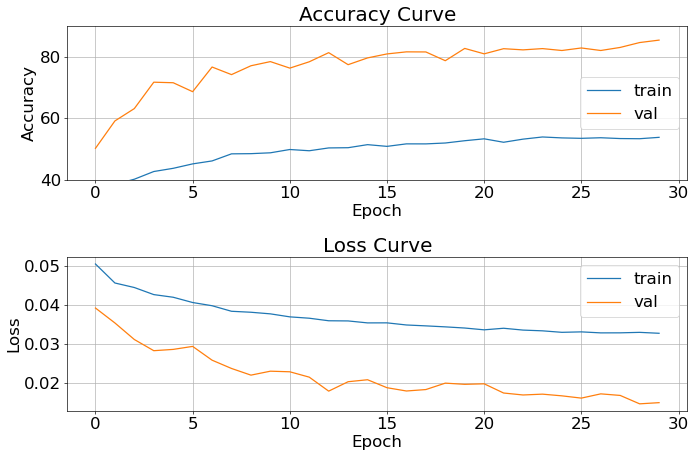

In [28]:
# 정확도(accuracy) 커브 시각화
plt.subplot(211)
plt.plot([i for i in range(epoch)], [i[0] for i in train_result])
plt.plot([i for i in range(epoch)], [i[0] for i in val_result])
plt.title("Accuracy Curve")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.ylim(40,90)
plt.grid()

plt.legend(["train", "val"])

# 손실(loss) 커브 시각화
plt.subplot(212)
plt.plot([i for i in range(epoch)], [i[1] for i in train_result])
plt.plot([i for i in range(epoch)], [i[1] for i in val_result])
plt.title("Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(["train", "val"])

plt.tight_layout()
plt.grid()
plt.show()

[ 각 클래스당 데이터 개수 ]
tensor([523, 540, 594, 599, 560, 591])
[ 혼동 행렬(confusion matrix) 시각화 ]


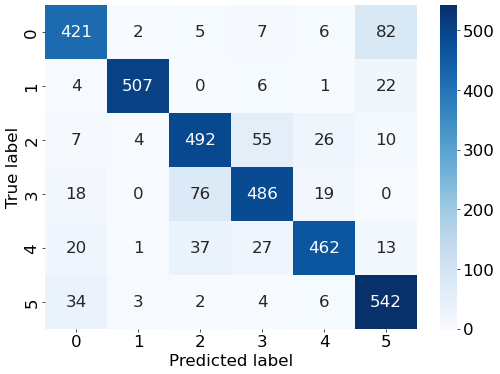

[ 각 클래스에 따른 정확도 ]
tensor([0.8050, 0.9389, 0.8283, 0.8114, 0.8250, 0.9171])
[ 전체 평균 정확도 ]
tensor(0.8541)


In [29]:
net = AlexNet()
net = net.to(device)

file_name = "./checkpoint/AlexNet.pt"
checkpoint = torch.load(file_name)
net.load_state_dict(checkpoint['net'])

# 평가 데이터셋을 이용해 혼동 행렬(confusion matrix) 계산하기
confusion_matrix = get_confusion_matrix(net, 6, val_dataloader)
print("[ 각 클래스당 데이터 개수 ]")
print(confusion_matrix.sum(1))

print("[ 혼동 행렬(confusion matrix) 시각화 ]")
res = pd.DataFrame(confusion_matrix.numpy(), index = [i for i in range(6)], columns = [i for i in range(6)])
res.index.name = 'True label'
res.columns.name = 'Predicted label'
plt.figure(figsize = (10, 7))
sns.heatmap(res, annot=True, fmt="d", cmap='Blues')
plt.show()

print("[ 각 클래스에 따른 정확도 ]")
# (각 클래스마다 정답 개수 / 각 클래스마다 데이터의 개수)
print(confusion_matrix.diag() / confusion_matrix.sum(1))

print("[ 전체 평균 정확도 ]")
print(confusion_matrix.diag().sum() / confusion_matrix.sum())

#### <b>(알아보기) LightResNet 아키텍처 살펴보기</b>

* [ResNet (2016 CVPR)](https://arxiv.org/abs/1512.03385) 논문에서 제안된 가벼운 ResNet을 PyTorch로 구현한 것은 다음과 같습니다.
    * 원본 논문에서는 CIFAR-10을 위하여 해당 아키텍처를 제안했습니다.
* 레이어의 깊이에 따라 다양한 버전이 있습니다.
    * 다양한 버전: 20 레이어, 32 레이어, 44 레이어, 56 레이어, 110 레이어
    * 일반적으로 더 깊은 레이어로 구성된 ResNet이 더 높은 정확도를 보입니다.

In [8]:
# ResNet을 위한 BasicBlock 클래스 정의
class BasicBlock(nn.Module):
    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()

        # 3x3 필터를 사용 (stride 값이 2라면, 너비와 높이가 절반으로 감소)
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes) # 배치 정규화(batch normalization)

        # 3x3 필터를 사용 (stride 값이 1이므로, 너비와 높이가 유지)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes) # 배치 정규화(batch normalization)

        self.shortcut = nn.Sequential() # identity인 경우
        if stride != 1: # stride가 1이 아니라면, identity mapping이 아닌 경우
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, planes, kernel_size=1, stride=stride, padding=0, bias=False),
                nn.BatchNorm2d(planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x) # (핵심) skip connection
        out = F.relu(out)
        return out


# LightResNet 클래스 정의
class LightResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=6):
        super(LightResNet, self).__init__()
        self.in_planes = 16

        # 16개의 3x3 필터(filter)를 사용
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        # 첫 레이어를 제외하고는 너비와 높이를 줄이기 위해 stride를 2로 설정
        self.layer1 = self._make_layer(block, 16, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 32, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 64, num_blocks[2], stride=2)
        self.linear = nn.Linear(64, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1) # 첫째 블록만 너비와 높이 감소
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes # 다음 레이어를 위해 채널 수 변경
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = F.avg_pool2d(out, out.size()[3])
        out = out.view(out.size(0), -1) # 배치(batch)를 제외한 모든 차원 flatten하기
        out = self.linear(out)
        return out


def LightResNet20():
    return LightResNet(BasicBlock, [3, 3, 3])


def LightResNet32():
    return LightResNet(BasicBlock, [5, 5, 5])


def LightResNet44():
    return LightResNet(BasicBlock, [7, 7, 7])


def LightResNet56():
    return LightResNet(BasicBlock, [9, 9, 9])


def LightResNet110():
    return LightResNet(BasicBlock, [18, 18, 18])

#### <b>(알아보기) LightResNet-20 학습하기</b>

* PyTorch로 구현된 LightResNet-20 모델을 학습해 봅시다.

In [29]:
net = LightResNet20()
net = net.to(device)

epoch = 30
learning_rate = 0.002
file_name = "LightResNet20.pt"

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9, weight_decay=0.0002)

train_result = []
val_result = []

start_time = time.time() # 시작 시간

for i in range(epoch):
    train_acc, train_loss = train(net, i, optimizer, criterion, train_dataloader) # 학습(training)
    val_acc, val_loss = validate(net, i + 1, val_dataloader) # 검증(validation)

    # 학습된 모델 저장하기
    state = {
        'net': net.state_dict()
    }
    if not os.path.isdir('checkpoint'):
        os.mkdir('checkpoint')
    torch.save(state, './checkpoint/' + file_name)
    print(f'Model saved! (time elapsed: {time.time() - start_time})')

    # 현재 epoch에서의 정확도(accuracy)와 손실(loss) 값 저장하기
    train_result.append((train_acc, train_loss))
    val_result.append((val_acc, val_loss))

[ Train epoch: 0 ]
Train accuarcy: 52.27122624201952
Train average loss: 0.036925067299397527
[ Validation epoch: 1 ]
Accuarcy: 66.65688288817141
Average loss: 0.028383759431276356
Model saved! (time elapsed: 7.991595029830933)
[ Train epoch: 1 ]
Train accuarcy: 65.44360460849784
Train average loss: 0.02879713814799378
[ Validation epoch: 2 ]
Accuarcy: 72.73260933372468
Average loss: 0.02358324907551702
Model saved! (time elapsed: 15.915268421173096)
[ Train epoch: 2 ]
Train accuarcy: 68.76788728260073
Train average loss: 0.02577841015513613
[ Validation epoch: 3 ]
Accuarcy: 77.10595832110361
Average loss: 0.01985306258876197
Model saved! (time elapsed: 24.0773024559021)
[ Train epoch: 3 ]
Train accuarcy: 72.02612460556249
Train average loss: 0.023524503669132005
[ Validation epoch: 4 ]
Accuarcy: 72.40974464338127
Average loss: 0.023405515757480393
Model saved! (time elapsed: 32.2518994808197)
[ Train epoch: 4 ]
Train accuarcy: 73.65524326704337
Train average loss: 0.022379831738243487

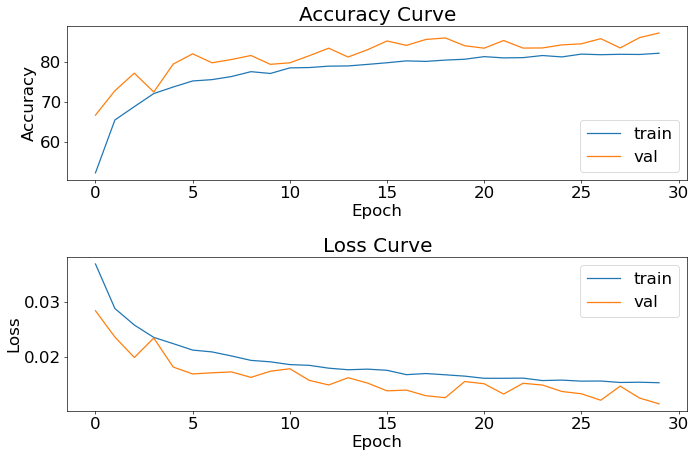

In [30]:
# 정확도(accuracy) 커브 시각화
plt.subplot(211)
plt.plot([i for i in range(epoch)], [i[0] for i in train_result])
plt.plot([i for i in range(epoch)], [i[0] for i in val_result])
plt.title("Accuracy Curve")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(["train", "val"])

# 손실(loss) 커브 시각화
plt.subplot(212)
plt.plot([i for i in range(epoch)], [i[1] for i in train_result])
plt.plot([i for i in range(epoch)], [i[1] for i in val_result])
plt.title("Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(["train", "val"])

plt.tight_layout()
plt.show()

[ 각 클래스당 데이터 개수 ]
tensor([523, 540, 594, 599, 560, 591])
[ 혼동 행렬(confusion matrix) 시각화 ]


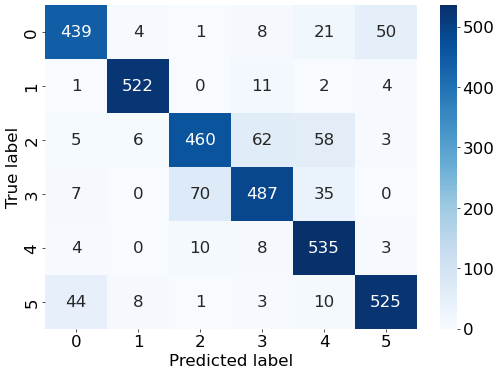

[ 각 클래스에 따른 정확도 ]
tensor([0.8394, 0.9667, 0.7744, 0.8130, 0.9554, 0.8883])
[ 전체 평균 정확도 ]
tensor(0.8711)


In [31]:
net = LightResNet20()
net = net.to(device)

file_name = "./checkpoint/LightResNet20.pt"
checkpoint = torch.load(file_name)
net.load_state_dict(checkpoint['net'])

# 평가 데이터셋을 이용해 혼동 행렬(confusion matrix) 계산하기
confusion_matrix = get_confusion_matrix(net, 6, val_dataloader)
print("[ 각 클래스당 데이터 개수 ]")
print(confusion_matrix.sum(1))

print("[ 혼동 행렬(confusion matrix) 시각화 ]")
res = pd.DataFrame(confusion_matrix.numpy(), index = [i for i in range(6)], columns = [i for i in range(6)])
res.index.name = 'True label'
res.columns.name = 'Predicted label'
plt.figure(figsize = (10, 7))
sns.heatmap(res, annot=True, fmt="d", cmap='Blues')
plt.show()

print("[ 각 클래스에 따른 정확도 ]")
# (각 클래스마다 정답 개수 / 각 클래스마다 데이터의 개수)
print(confusion_matrix.diag() / confusion_matrix.sum(1))

print("[ 전체 평균 정확도 ]")
print(confusion_matrix.diag().sum() / confusion_matrix.sum())

#### <b>Problem 5. 다양한 레이어 깊이에 따라 LightResNet 학습하기</b>

* Residual Block을 사용하는 경우 깊이가 깊어져도 좋은 성능을 내는 경향이 있습니다.
* 다음의 LightResNet 모델들에 대하여 각각 학습을 진행한 뒤에, 검증 정확도(validation accuracy)를 쓰세요.
    * LightResNet32: {0.8559}
    * LightResNet56: {0.8571}
    * LightResNet110: {0.8242}
* 레이어가 깊어짐에 따라서 성능이 좋아지나요? {아니요.}
    * 그 이유는: {레이어가 깊어지면 깊어질 수록 학습을 더 많이 해야하는데, 30번이라는 작은 epoch만 돌려서 그런 것일 수 있다.}

****************************** LightResNet32.pt ******************************
[ Train epoch: 0 ]
Train accuarcy: 51.295222719600794
Train average loss: 0.03733474306623891
[ Validation epoch: 1 ]
Accuarcy: 65.89374816554154
Average loss: 0.027705043423095335
[ Train epoch: 1 ]
Train accuarcy: 63.27144639318999
Train average loss: 0.02948489378192695
[ Validation epoch: 2 ]
Accuarcy: 73.14352803052539
Average loss: 0.022735748957216056
[ Train epoch: 2 ]
Train accuarcy: 68.37161517575402
Train average loss: 0.026161995872832224
[ Validation epoch: 3 ]
Accuarcy: 72.3803933078955
Average loss: 0.022838821386990046
[ Train epoch: 3 ]
Train accuarcy: 70.55111176341087
Train average loss: 0.024343483680900897
[ Validation epoch: 4 ]
Accuarcy: 71.64660992075139
Average loss: 0.02368368904262405
[ Train epoch: 4 ]
Train accuarcy: 73.22227929845161
Train average loss: 0.022830095761868733
[ Validation epoch: 5 ]
Accuarcy: 73.7892574112122
Average loss: 0.021576241030523705
[ Train epoch: 5 ]
T

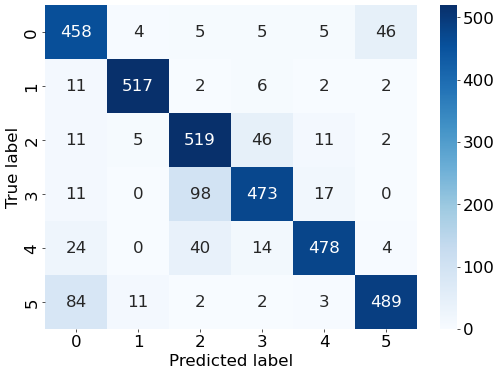

[ 각 클래스에 따른 정확도 ]
tensor([0.8757, 0.9574, 0.8737, 0.7896, 0.8536, 0.8274])
[ 전체 평균 정확도 ]
tensor(0.8612)
****************************** LightResNet56.pt ******************************
[ Train epoch: 0 ]
Train accuarcy: 49.724811036912016
Train average loss: 0.03825554253639142
[ Validation epoch: 1 ]
Accuarcy: 60.639859113589665
Average loss: 0.030073268815223375
[ Train epoch: 1 ]
Train accuarcy: 60.497541645263084
Train average loss: 0.031419184405271625
[ Validation epoch: 2 ]
Accuarcy: 67.86028764308776
Average loss: 0.02635937208369361
[ Train epoch: 2 ]
Train accuarcy: 64.78315109708667
Train average loss: 0.02867193911433736
[ Validation epoch: 3 ]
Accuarcy: 73.81860874669798
Average loss: 0.023305920166181337
[ Train epoch: 3 ]
Train accuarcy: 68.98803845307111
Train average loss: 0.026094087352316685
[ Validation epoch: 4 ]
Accuarcy: 75.31552685647198
Average loss: 0.021305159359759237
[ Train epoch: 4 ]
Train accuarcy: 70.00807220958391
Train average loss: 0.02471686923391026


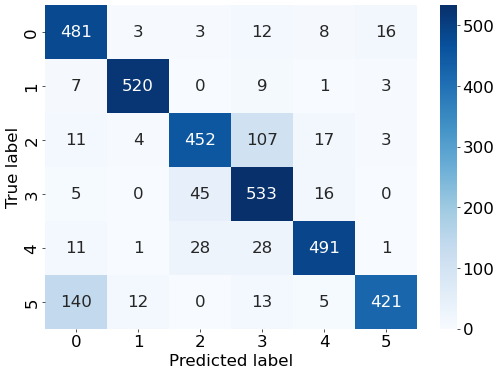

[ 각 클래스에 따른 정확도 ]
tensor([0.9197, 0.9630, 0.7609, 0.8898, 0.8768, 0.7124])
[ 전체 평균 정확도 ]
tensor(0.8506)
****************************** LightResNet110.pt ******************************
[ Train epoch: 0 ]
Train accuarcy: 46.5546341821384
Train average loss: 0.04115980603317526
[ Validation epoch: 1 ]
Accuarcy: 63.252127971822716
Average loss: 0.030077041017718773
[ Train epoch: 1 ]
Train accuarcy: 57.9658031848536
Train average loss: 0.033716844451255126
[ Validation epoch: 2 ]
Accuarcy: 64.71969474611095
Average loss: 0.028871921506976324
[ Train epoch: 2 ]
Train accuarcy: 62.9925882439275
Train average loss: 0.030341762382600824
[ Validation epoch: 3 ]
Accuarcy: 68.44731435280305
Average loss: 0.0252003424374771
[ Train epoch: 3 ]
Train accuarcy: 66.22147207749322
Train average loss: 0.028066631930060055
[ Validation epoch: 4 ]
Accuarcy: 73.75990607572645
Average loss: 0.022649629237821874
[ Train epoch: 4 ]
Train accuarcy: 68.07074190944448
Train average loss: 0.026662118928119462
[ V

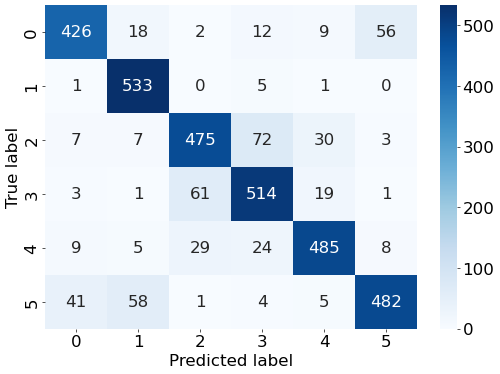

[ 각 클래스에 따른 정확도 ]
tensor([0.8145, 0.9870, 0.7997, 0.8581, 0.8661, 0.8156])
[ 전체 평균 정확도 ]
tensor(0.8556)


In [32]:
model_list = [32,56,110]
for models in model_list:
    net = globals()[f"LightResNet{models}"]()
    net = net.to(device)

    epoch = 30
    learning_rate = 0.002
    file_name = "LightResNet"+str(models)+".pt"

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9, weight_decay=0.0002)

    train_result = []
    val_result = []

    start_time = time.time() # 시작 시간
    print("*"*30,"LightResNet"+str(models)+".pt","*"*30)
    for i in range(epoch):
        train_acc, train_loss = train(net, i, optimizer, criterion, train_dataloader) # 학습(training)
        val_acc, val_loss = validate(net, i + 1, val_dataloader) # 검증(validation)

        # 학습된 모델 저장하기
        state = {
            'net': net.state_dict()
        }
        if not os.path.isdir('checkpoint'):
            os.mkdir('checkpoint')
        torch.save(state, './checkpoint/' + file_name)
#         print(f'Model saved! (time elapsed: {time.time() - start_time})')

        # 현재 epoch에서의 정확도(accuracy)와 손실(loss) 값 저장하기
        train_result.append((train_acc, train_loss))
        val_result.append((val_acc, val_loss))
        
    checkpoint = torch.load('./checkpoint/' + file_name)
    net.load_state_dict(checkpoint['net'])

    # 평가 데이터셋을 이용해 혼동 행렬(confusion matrix) 계산하기
    confusion_matrix = get_confusion_matrix(net, 6, val_dataloader)
    print("[ 각 클래스당 데이터 개수 ]")
    print(confusion_matrix.sum(1))

    print("[ 혼동 행렬(confusion matrix) 시각화 ]")
    res = pd.DataFrame(confusion_matrix.numpy(), index = [i for i in range(6)], columns = [i for i in range(6)])
    res.index.name = 'True label'
    res.columns.name = 'Predicted label'
    plt.figure(figsize = (10, 7))
    sns.heatmap(res, annot=True, fmt="d", cmap='Blues')
    plt.show()

    print("[ 각 클래스에 따른 정확도 ]")
    # (각 클래스마다 정답 개수 / 각 클래스마다 데이터의 개수)
    print(confusion_matrix.diag() / confusion_matrix.sum(1))

    print("[ 전체 평균 정확도 ]")
    print(confusion_matrix.diag().sum() / confusion_matrix.sum())

#### 추가 실험(epoch가 높으면 평균 정확도가 올라가는지 실험)

****************************** LightResNet20.pt ******************************
[ Train epoch: 0 ]
Train accuarcy: 52.56476113598004
Train average loss: 0.036672892386437235
[ Validation epoch: 1 ]
Accuarcy: 61.90196653947755
Average loss: 0.03120012212646368
[ Train epoch: 1 ]
Train accuarcy: 63.792470829969915
Train average loss: 0.029211249898777693
[ Validation epoch: 2 ]
Accuarcy: 70.32579982389198
Average loss: 0.024701381861586217
[ Train epoch: 2 ]
Train accuarcy: 69.62647684743524
Train average loss: 0.025719333195394156
[ Validation epoch: 3 ]
Accuarcy: 64.0152626944526
Average loss: 0.030050116434522763
[ Train epoch: 3 ]
Train accuarcy: 71.98943274381742
Train average loss: 0.02382002901136897
[ Validation epoch: 4 ]
Accuarcy: 77.6929850308189
Average loss: 0.01937995346753451
[ Train epoch: 4 ]
Train accuarcy: 73.09018859616937
Train average loss: 0.022726163107344398
[ Validation epoch: 5 ]
Accuarcy: 80.42265923099501
Average loss: 0.017773892729381048
[ Train epoch: 5 ]
T

Train accuarcy: 84.08307037499083
Train average loss: 0.01386523185200935
[ Validation epoch: 46 ]
Accuarcy: 84.79600821837394
Average loss: 0.013641813431522312
[ Train epoch: 46 ]
Train accuarcy: 83.7308285022382
Train average loss: 0.013912055406583032
[ Validation epoch: 47 ]
Accuarcy: 83.71000880540065
Average loss: 0.013948916212393456
[ Train epoch: 47 ]
Train accuarcy: 84.00234827915169
Train average loss: 0.013691465481279216
[ Validation epoch: 48 ]
Accuarcy: 84.61990020545934
Average loss: 0.013696482835328226
[ Train epoch: 48 ]
Train accuarcy: 84.20782270492404
Train average loss: 0.013629302790345682
[ Validation epoch: 49 ]
Accuarcy: 87.43762841209275
Average loss: 0.01105411333669691
[ Train epoch: 49 ]
Train accuarcy: 84.2958831731122
Train average loss: 0.013334796814599391
[ Validation epoch: 50 ]
Accuarcy: 87.29087173466392
Average loss: 0.010817817136500985
[ 각 클래스당 데이터 개수 ]
tensor([523, 540, 594, 599, 560, 591])
[ 혼동 행렬(confusion matrix) 시각화 ]


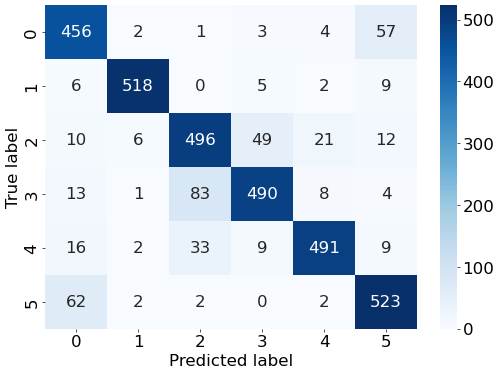

[ 각 클래스에 따른 정확도 ]
tensor([0.8719, 0.9593, 0.8350, 0.8180, 0.8768, 0.8849])
[ 전체 평균 정확도 ]
tensor(0.8729)


In [64]:
model_list = [20]
for models in model_list:
    net = globals()[f"LightResNet{models}"]()
    net = net.to(device)

    epoch = 50
    learning_rate = 0.002
    file_name = "LightResNet"+str(models)+"diff_epoch"+str(epoch)+".pt"

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9, weight_decay=0.0002)

    train_result = []
    val_result = []

    start_time = time.time() # 시작 시간
    print("*"*30,"LightResNet"+str(models)+".pt","*"*30)
    for i in range(epoch):
        train_acc, train_loss = train(net, i, optimizer, criterion, train_dataloader) # 학습(training)
        val_acc, val_loss = validate(net, i + 1, val_dataloader) # 검증(validation)

        # 학습된 모델 저장하기
        state = {
            'net': net.state_dict()
        }
        if not os.path.isdir('checkpoint'):
            os.mkdir('checkpoint')
        torch.save(state, './checkpoint/' + file_name)
#         print(f'Model saved! (time elapsed: {time.time() - start_time})')

        # 현재 epoch에서의 정확도(accuracy)와 손실(loss) 값 저장하기
        train_result.append((train_acc, train_loss))
        val_result.append((val_acc, val_loss))
        
    checkpoint = torch.load('./checkpoint/' + file_name)
    net.load_state_dict(checkpoint['net'])

    # 평가 데이터셋을 이용해 혼동 행렬(confusion matrix) 계산하기
    confusion_matrix = get_confusion_matrix(net, 6, val_dataloader)
    print("[ 각 클래스당 데이터 개수 ]")
    print(confusion_matrix.sum(1))

    print("[ 혼동 행렬(confusion matrix) 시각화 ]")
    res = pd.DataFrame(confusion_matrix.numpy(), index = [i for i in range(6)], columns = [i for i in range(6)])
    res.index.name = 'True label'
    res.columns.name = 'Predicted label'
    plt.figure(figsize = (10, 7))
    sns.heatmap(res, annot=True, fmt="d", cmap='Blues')
    plt.show()

    print("[ 각 클래스에 따른 정확도 ]")
    # (각 클래스마다 정답 개수 / 각 클래스마다 데이터의 개수)
    print(confusion_matrix.diag() / confusion_matrix.sum(1))

    print("[ 전체 평균 정확도 ]")
    print(confusion_matrix.diag().sum() / confusion_matrix.sum())

****************************** LightResNet32.pt ******************************
[ Train epoch: 0 ]
Train accuarcy: 50.56138548469949
Train average loss: 0.037439555671128104
[ Validation epoch: 1 ]
Accuarcy: 64.837100088054
Average loss: 0.028593626283360676
[ Train epoch: 1 ]
Train accuarcy: 62.54494753063771
Train average loss: 0.029851021217374325
[ Validation epoch: 2 ]
Accuarcy: 67.50807161725858
Average loss: 0.026973206065496743
[ Train epoch: 2 ]
Train accuarcy: 67.62310119615469
Train average loss: 0.026651606152882937
[ Validation epoch: 3 ]
Accuarcy: 70.58996184326386
Average loss: 0.024535752546412874
[ Train epoch: 3 ]
Train accuarcy: 71.0721362001908
Train average loss: 0.024393095882761073
[ Validation epoch: 4 ]
Accuarcy: 77.2820663340182
Average loss: 0.019271251976507517
[ Train epoch: 4 ]
Train accuarcy: 72.45175020180524
Train average loss: 0.02325287384735634
[ Validation epoch: 5 ]
Accuarcy: 78.92574112122101
Average loss: 0.01844611069849589
[ Train epoch: 5 ]
Tra

Train accuarcy: 83.92162618331254
Train average loss: 0.013722520289622635
[ Validation epoch: 46 ]
Accuarcy: 88.05400645729381
Average loss: 0.010935868813139902
[ Train epoch: 46 ]
Train accuarcy: 84.57474132237469
Train average loss: 0.013204985867726214
[ Validation epoch: 47 ]
Accuarcy: 88.31816847666569
Average loss: 0.011193539309806056
[ Train epoch: 47 ]
Train accuarcy: 84.31789829015925
Train average loss: 0.013353689051215941
[ Validation epoch: 48 ]
Accuarcy: 85.17757557968888
Average loss: 0.013387328020338268
[ Train epoch: 48 ]
Train accuarcy: 84.44998899244148
Train average loss: 0.013323262094392845
[ Validation epoch: 49 ]
Accuarcy: 87.17346639272087
Average loss: 0.01147012064402356
[ Train epoch: 49 ]
Train accuarcy: 84.59675643942174
Train average loss: 0.013216660337576892
[ Validation epoch: 50 ]
Accuarcy: 87.52568241855005
Average loss: 0.011304104615944307
[ 각 클래스당 데이터 개수 ]
tensor([523, 540, 594, 599, 560, 591])
[ 혼동 행렬(confusion matrix) 시각화 ]


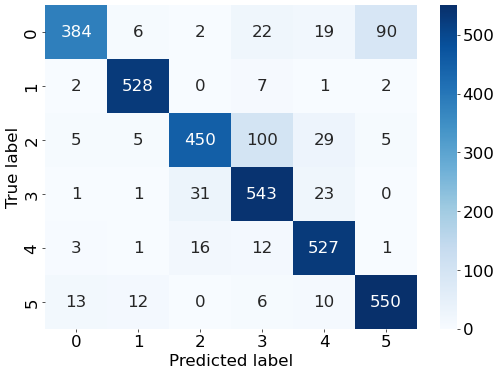

[ 각 클래스에 따른 정확도 ]
tensor([0.7342, 0.9778, 0.7576, 0.9065, 0.9411, 0.9306])
[ 전체 평균 정확도 ]
tensor(0.8753)
****************************** LightResNet56.pt ******************************
[ Train epoch: 0 ]
Train accuarcy: 50.15777500550378
Train average loss: 0.03813804120181845
[ Validation epoch: 1 ]
Accuarcy: 66.77428823011446
Average loss: 0.027188379130546808
[ Train epoch: 1 ]
Train accuarcy: 63.87319292580906
Train average loss: 0.029526006786596
[ Validation epoch: 2 ]
Accuarcy: 66.65688288817141
Average loss: 0.026322828855618097
[ Train epoch: 2 ]
Train accuarcy: 67.61576282380568
Train average loss: 0.026676145892959614
[ Validation epoch: 3 ]
Accuarcy: 76.13736425007338
Average loss: 0.020703106191384327
[ Train epoch: 3 ]
Train accuarcy: 70.13282453951713
Train average loss: 0.024813849369883144
[ Validation epoch: 4 ]
Accuarcy: 67.91899031405929
Average loss: 0.02607701214520785
[ Train epoch: 4 ]
Train accuarcy: 72.01878623321348
Train average loss: 0.023383340948333286
[ Va

Train accuarcy: 83.81155059807735
Train average loss: 0.01395195467575128
[ Validation epoch: 45 ]
Accuarcy: 88.40622248312299
Average loss: 0.010523199718002703
[ Train epoch: 45 ]
Train accuarcy: 84.33257503485727
Train average loss: 0.013393528710271902
[ Validation epoch: 46 ]
Accuarcy: 88.40622248312299
Average loss: 0.010759119153250198
[ Train epoch: 46 ]
Train accuarcy: 84.33991340720628
Train average loss: 0.013377416567017032
[ Validation epoch: 47 ]
Accuarcy: 88.23011447020839
Average loss: 0.010712127945606472
[ Train epoch: 47 ]
Train accuarcy: 84.2958831731122
Train average loss: 0.01335296488725895
[ Validation epoch: 48 ]
Accuarcy: 87.49633108306428
Average loss: 0.011435717224007588
[ Train epoch: 48 ]
Train accuarcy: 84.22983782197109
Train average loss: 0.013562674130532278
[ Validation epoch: 49 ]
Accuarcy: 85.97006163780452
Average loss: 0.012486983817765045
[ Train epoch: 49 ]
Train accuarcy: 84.15645409848096
Train average loss: 0.013438986009229452
[ Validation 

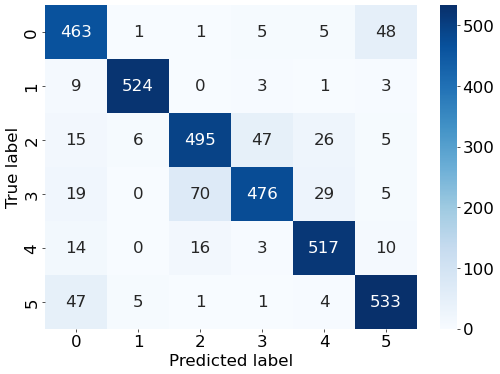

[ 각 클래스에 따른 정확도 ]
tensor([0.8853, 0.9704, 0.8333, 0.7947, 0.9232, 0.9019])
[ 전체 평균 정확도 ]
tensor(0.8829)
****************************** LightResNet110.pt ******************************
[ Train epoch: 0 ]
Train accuarcy: 46.92889117193806
Train average loss: 0.041308012420348886
[ Validation epoch: 1 ]
Accuarcy: 55.00440270032286
Average loss: 0.03405232028174617
[ Train epoch: 1 ]
Train accuarcy: 57.907096206061496
Train average loss: 0.0335644290584929
[ Validation epoch: 2 ]
Accuarcy: 64.36747872028177
Average loss: 0.029691067510313186
[ Train epoch: 2 ]
Train accuarcy: 64.13003595802451
Train average loss: 0.029481472583792308
[ Validation epoch: 3 ]
Accuarcy: 74.8752568241855
Average loss: 0.021709463526015063
[ Train epoch: 3 ]
Train accuarcy: 67.25618257870404
Train average loss: 0.027225612319031037
[ Validation epoch: 4 ]
Accuarcy: 63.927208687995304
Average loss: 0.03152979545170588
[ Train epoch: 4 ]
Train accuarcy: 70.13282453951713
Train average loss: 0.02523208401510561
[ 

Train accuarcy: 84.08307037499083
Train average loss: 0.013702696915233424
[ Validation epoch: 45 ]
Accuarcy: 86.41033167009098
Average loss: 0.012105265604389494
[ Train epoch: 45 ]
Train accuarcy: 83.48132384237176
Train average loss: 0.013994169564811204
[ Validation epoch: 46 ]
Accuarcy: 88.5529791605518
Average loss: 0.010517768288484443
[ Train epoch: 46 ]
Train accuarcy: 83.73816687458722
Train average loss: 0.013853355460325446
[ Validation epoch: 47 ]
Accuarcy: 87.20281772820664
Average loss: 0.011615985132467373
[ Train epoch: 47 ]
Train accuarcy: 83.76018199163425
Train average loss: 0.013871482630516784
[ Validation epoch: 48 ]
Accuarcy: 87.1441150572351
Average loss: 0.011835745264348796
[ Train epoch: 48 ]
Train accuarcy: 84.09040874733984
Train average loss: 0.01402541898382885
[ Validation epoch: 49 ]
Accuarcy: 87.6430877604931
Average loss: 0.010958550414242702
[ Train epoch: 49 ]
Train accuarcy: 83.73816687458722
Train average loss: 0.013837285469412375
[ Validation e

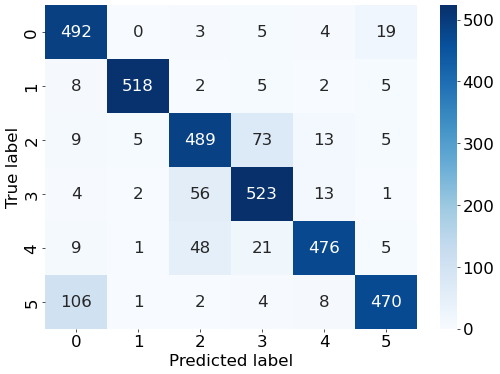

[ 각 클래스에 따른 정확도 ]
tensor([0.9407, 0.9593, 0.8232, 0.8731, 0.8500, 0.7953])
[ 전체 평균 정확도 ]
tensor(0.8711)


In [63]:
model_list = [32,56,110]
for models in model_list:
    net = globals()[f"LightResNet{models}"]()
    net = net.to(device)

    epoch = 50
    learning_rate = 0.002
    file_name = "LightResNet"+str(models)+"diff_epoch"+str(epoch)+".pt"

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9, weight_decay=0.0002)

    train_result = []
    val_result = []

    start_time = time.time() # 시작 시간
    print("*"*30,"LightResNet"+str(models)+".pt","*"*30)
    for i in range(epoch):
        train_acc, train_loss = train(net, i, optimizer, criterion, train_dataloader) # 학습(training)
        val_acc, val_loss = validate(net, i + 1, val_dataloader) # 검증(validation)

        # 학습된 모델 저장하기
        state = {
            'net': net.state_dict()
        }
        if not os.path.isdir('checkpoint'):
            os.mkdir('checkpoint')
        torch.save(state, './checkpoint/' + file_name)
#         print(f'Model saved! (time elapsed: {time.time() - start_time})')

        # 현재 epoch에서의 정확도(accuracy)와 손실(loss) 값 저장하기
        train_result.append((train_acc, train_loss))
        val_result.append((val_acc, val_loss))
        
    checkpoint = torch.load('./checkpoint/' + file_name)
    net.load_state_dict(checkpoint['net'])

    # 평가 데이터셋을 이용해 혼동 행렬(confusion matrix) 계산하기
    confusion_matrix = get_confusion_matrix(net, 6, val_dataloader)
    print("[ 각 클래스당 데이터 개수 ]")
    print(confusion_matrix.sum(1))

    print("[ 혼동 행렬(confusion matrix) 시각화 ]")
    res = pd.DataFrame(confusion_matrix.numpy(), index = [i for i in range(6)], columns = [i for i in range(6)])
    res.index.name = 'True label'
    res.columns.name = 'Predicted label'
    plt.figure(figsize = (10, 7))
    sns.heatmap(res, annot=True, fmt="d", cmap='Blues')
    plt.show()

    print("[ 각 클래스에 따른 정확도 ]")
    # (각 클래스마다 정답 개수 / 각 클래스마다 데이터의 개수)
    print(confusion_matrix.diag() / confusion_matrix.sum(1))

    print("[ 전체 평균 정확도 ]")
    print(confusion_matrix.diag().sum() / confusion_matrix.sum())

****************************** LightResNet20.pt ******************************
[ Train epoch: 0 ]
Train accuarcy: 51.63278784765539
Train average loss: 0.036838275763226895
[ Validation epoch: 1 ]
Accuarcy: 57.41121221015556
Average loss: 0.03172357634501546
[ Train epoch: 1 ]
Train accuarcy: 63.33749174433111
Train average loss: 0.030082664202286107
[ Validation epoch: 2 ]
Accuarcy: 70.09098914000587
Average loss: 0.02612412735133147
[ Train epoch: 2 ]
Train accuarcy: 67.75519189843693
Train average loss: 0.026827819928075262
[ Validation epoch: 3 ]
Accuarcy: 71.5585559142941
Average loss: 0.023083842890613198
[ Train epoch: 3 ]
Train accuarcy: 71.23358039186908
Train average loss: 0.02417362065441918
[ Validation epoch: 4 ]
Accuarcy: 79.07249779864983
Average loss: 0.01861636610474795
[ Train epoch: 4 ]
Train accuarcy: 73.31033976663976
Train average loss: 0.022914338900948985
[ Validation epoch: 5 ]
Accuarcy: 75.81449955972997
Average loss: 0.02104463535632981
[ Train epoch: 5 ]
Tra

Train accuarcy: 83.68679826814413
Train average loss: 0.013732454069398894
[ Validation epoch: 46 ]
Accuarcy: 87.34957440563545
Average loss: 0.011678205307169608
[ Train epoch: 46 ]
Train accuarcy: 83.99500990680266
Train average loss: 0.01342752613381471
[ Validation epoch: 47 ]
Accuarcy: 87.20281772820664
Average loss: 0.011268081712624807
[ Train epoch: 47 ]
Train accuarcy: 83.90694943861452
Train average loss: 0.013733168579367362
[ Validation epoch: 48 ]
Accuarcy: 87.93660111535075
Average loss: 0.010850886961634922
[ Train epoch: 48 ]
Train accuarcy: 84.0683936302928
Train average loss: 0.013531063389793884
[ Validation epoch: 49 ]
Accuarcy: 87.7311417669504
Average loss: 0.011028137371831882
[ Train epoch: 49 ]
Train accuarcy: 84.2958831731122
Train average loss: 0.013378056707320616
[ Validation epoch: 50 ]
Accuarcy: 86.55708834751981
Average loss: 0.011515475409381509
[ Train epoch: 50 ]
Train accuarcy: 84.178469215528
Train average loss: 0.013437664734299835
[ Validation epo

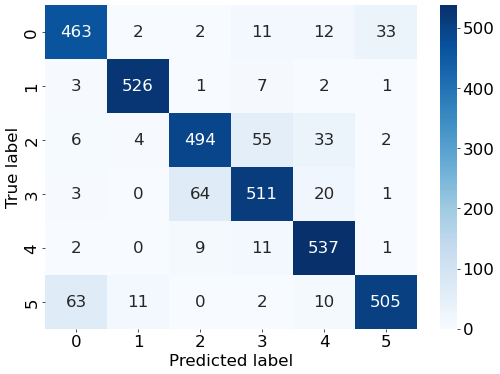

[ 각 클래스에 따른 정확도 ]
tensor([0.8853, 0.9741, 0.8316, 0.8531, 0.9589, 0.8545])
[ 전체 평균 정확도 ]
tensor(0.8911)
****************************** LightResNet20.pt ******************************
[ Train epoch: 0 ]
Train accuarcy: 51.992368092757026
Train average loss: 0.036800645435600875
[ Validation epoch: 1 ]
Accuarcy: 59.49515702964485
Average loss: 0.030265230087370407
[ Train epoch: 1 ]
Train accuarcy: 65.39223600205474
Train average loss: 0.028079507729623483
[ Validation epoch: 2 ]
Accuarcy: 71.32374523040798
Average loss: 0.025305384812132507
[ Train epoch: 2 ]
Train accuarcy: 70.11814779481911
Train average loss: 0.024932910699771577
[ Validation epoch: 3 ]
Accuarcy: 75.2861755209862
Average loss: 0.020893914243990914
[ Train epoch: 3 ]
Train accuarcy: 72.58384090408747
Train average loss: 0.02288038813115181
[ Validation epoch: 4 ]
Accuarcy: 74.93395949515703
Average loss: 0.020846305169560955
[ Train epoch: 4 ]
Train accuarcy: 73.3910618624789
Train average loss: 0.022145607478989363
[

Train accuarcy: 84.20048433257503
Train average loss: 0.013531163655242786
[ Validation epoch: 45 ]
Accuarcy: 88.40622248312299
Average loss: 0.010848643526649208
[ Train epoch: 45 ]
Train accuarcy: 84.02436339619872
Train average loss: 0.01347247168061983
[ Validation epoch: 46 ]
Accuarcy: 87.11476372174934
Average loss: 0.011946109008992001
[ Train epoch: 46 ]
Train accuarcy: 83.95831804505761
Train average loss: 0.013864164007263802
[ Validation epoch: 47 ]
Accuarcy: 87.5550337540358
Average loss: 0.011347585185238228
[ Train epoch: 47 ]
Train accuarcy: 84.11242386438688
Train average loss: 0.01372401298804863
[ Validation epoch: 48 ]
Accuarcy: 86.55708834751981
Average loss: 0.011042516868827209
[ Train epoch: 48 ]
Train accuarcy: 84.3545901519043
Train average loss: 0.013432483589508357
[ Validation epoch: 49 ]
Accuarcy: 87.34957440563545
Average loss: 0.01199792962524595
[ Train epoch: 49 ]
Train accuarcy: 83.95831804505761
Train average loss: 0.01362271700854031
[ Validation epo

Train accuarcy: 86.54142511191017
Train average loss: 0.01157871550661877
[ Validation epoch: 90 ]
Accuarcy: 89.28676254769591
Average loss: 0.010145063377262946
[ Train epoch: 90 ]
Train accuarcy: 86.12313788801644
Train average loss: 0.011758055022625927
[ Validation epoch: 91 ]
Accuarcy: 86.43968300557675
Average loss: 0.012298832611146126
[ Train epoch: 91 ]
Train accuarcy: 86.09378439862039
Train average loss: 0.01178788969738429
[ Validation epoch: 92 ]
Accuarcy: 88.99324919283828
Average loss: 0.009743624255564125
[ Train epoch: 92 ]
Train accuarcy: 86.0497541645263
Train average loss: 0.01167074695733635
[ Validation epoch: 93 ]
Accuarcy: 88.58233049603757
Average loss: 0.01046247183314369
[ Train epoch: 93 ]
Train accuarcy: 86.2772437073457
Train average loss: 0.011563248374128478
[ Validation epoch: 94 ]
Accuarcy: 89.22805987672439
Average loss: 0.009752425840515387
[ Train epoch: 94 ]
Train accuarcy: 86.36530417553386
Train average loss: 0.011703562736948631
[ Validation epo

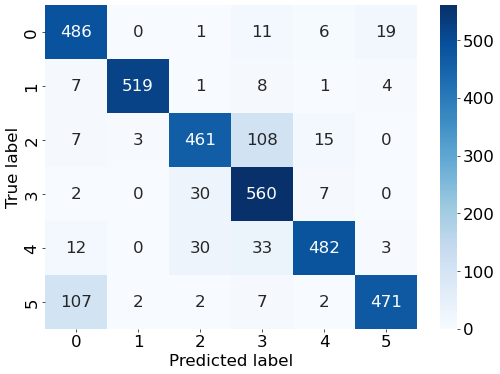

[ 각 클래스에 따른 정확도 ]
tensor([0.9293, 0.9611, 0.7761, 0.9349, 0.8607, 0.7970])
[ 전체 평균 정확도 ]
tensor(0.8744)
****************************** LightResNet32.pt ******************************
[ Train epoch: 0 ]
Train accuarcy: 50.82556688926396
Train average loss: 0.03742756839717765
[ Validation epoch: 1 ]
Accuarcy: 61.46169650719108
Average loss: 0.031308342747790464
[ Train epoch: 1 ]
Train accuarcy: 63.24943127614295
Train average loss: 0.02960830175877492
[ Validation epoch: 2 ]
Accuarcy: 67.94834164954506
Average loss: 0.026337039008810962
[ Train epoch: 2 ]
Train accuarcy: 68.4156454098481
Train average loss: 0.02633842793959309
[ Validation epoch: 3 ]
Accuarcy: 70.73671852069269
Average loss: 0.02471857357661956
[ Train epoch: 3 ]
Train accuarcy: 71.33631760475527
Train average loss: 0.02415856172921784
[ Validation epoch: 4 ]
Accuarcy: 71.82271793366598
Average loss: 0.0229738231607291
[ Train epoch: 4 ]
Train accuarcy: 72.9947897556322
Train average loss: 0.02302736793198099
[ Validat

Train accuarcy: 83.72349012988919
Train average loss: 0.013878911611155018
[ Validation epoch: 45 ]
Accuarcy: 86.11681831523335
Average loss: 0.011844602460766034
[ Train epoch: 45 ]
Train accuarcy: 83.64276803405005
Train average loss: 0.013499153208652123
[ Validation epoch: 46 ]
Accuarcy: 88.11270912826534
Average loss: 0.010524174431953956
[ Train epoch: 46 ]
Train accuarcy: 84.15645409848096
Train average loss: 0.013551838364124894
[ Validation epoch: 47 ]
Accuarcy: 85.52979160551806
Average loss: 0.013084640155133874
[ Train epoch: 47 ]
Train accuarcy: 83.98033316210464
Train average loss: 0.01342784971000951
[ Validation epoch: 48 ]
Accuarcy: 88.46492515409452
Average loss: 0.010524218571231552
[ Train epoch: 48 ]
Train accuarcy: 84.50869597123358
Train average loss: 0.013330072420415152
[ Validation epoch: 49 ]
Accuarcy: 86.96800704432052
Average loss: 0.01150860304807266
[ Train epoch: 49 ]
Train accuarcy: 84.38394364130036
Train average loss: 0.013265054296518164
[ Validation

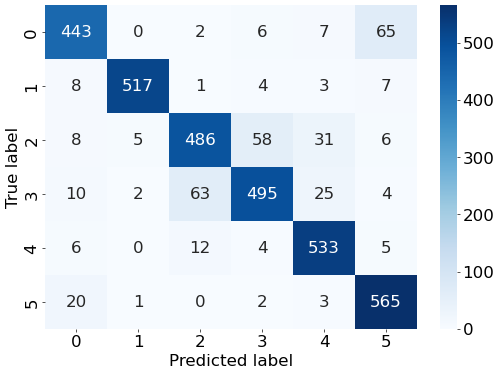

[ 각 클래스에 따른 정확도 ]
tensor([0.8470, 0.9574, 0.8182, 0.8264, 0.9518, 0.9560])
[ 전체 평균 정확도 ]
tensor(0.8920)
****************************** LightResNet32.pt ******************************
[ Train epoch: 0 ]
Train accuarcy: 51.955676231011964
Train average loss: 0.03677939049450695
[ Validation epoch: 1 ]
Accuarcy: 61.49104784267684
Average loss: 0.029031488127046434
[ Train epoch: 1 ]
Train accuarcy: 63.49159756366038
Train average loss: 0.02966038904493095
[ Validation epoch: 2 ]
Accuarcy: 73.99471675961256
Average loss: 0.02249158161771868
[ Train epoch: 2 ]
Train accuarcy: 68.84860937843986
Train average loss: 0.025875768061297266
[ Validation epoch: 3 ]
Accuarcy: 72.29233930143822
Average loss: 0.02311087798820341
[ Train epoch: 3 ]
Train accuarcy: 71.93806413737433
Train average loss: 0.023963672380205244
[ Validation epoch: 4 ]
Accuarcy: 74.66979747578515
Average loss: 0.0208021701956761
[ Train epoch: 4 ]
Train accuarcy: 73.55250605415719
Train average loss: 0.0223725909198941
[ Vali

Accuarcy: 83.59260346345759
Average loss: 0.014372607121762903
[ Train epoch: 45 ]
Train accuarcy: 84.00234827915169
Train average loss: 0.013352585275065412
[ Validation epoch: 46 ]
Accuarcy: 86.58643968300558
Average loss: 0.0117055571036392
[ Train epoch: 46 ]
Train accuarcy: 83.90694943861452
Train average loss: 0.013670878663222788
[ Validation epoch: 47 ]
Accuarcy: 87.05606105077781
Average loss: 0.011415368822406806
[ Train epoch: 47 ]
Train accuarcy: 84.20048433257503
Train average loss: 0.01346096122305103
[ Validation epoch: 48 ]
Accuarcy: 88.34751981215145
Average loss: 0.010802793113986593
[ Train epoch: 48 ]
Train accuarcy: 84.05371688559478
Train average loss: 0.013367472472776625
[ Validation epoch: 49 ]
Accuarcy: 87.34957440563545
Average loss: 0.011455609375408118
[ Train epoch: 49 ]
Train accuarcy: 83.97299478975563
Train average loss: 0.013400875177383947
[ Validation epoch: 50 ]
Accuarcy: 87.93660111535075
Average loss: 0.010754489106169047
[ Train epoch: 50 ]
Train

Accuarcy: 89.0519518638098
Average loss: 0.010363110091558013
[ Train epoch: 90 ]
Train accuarcy: 86.60013209070229
Train average loss: 0.011289869777466236
[ Validation epoch: 91 ]
Accuarcy: 89.66832990901086
Average loss: 0.009850717001789506
[ Train epoch: 91 ]
Train accuarcy: 86.98172745285096
Train average loss: 0.011071436357570777
[ Validation epoch: 92 ]
Accuarcy: 89.43351922512474
Average loss: 0.009896230321057143
[ Train epoch: 92 ]
Train accuarcy: 86.82762163352169
Train average loss: 0.011229300151009846
[ Validation epoch: 93 ]
Accuarcy: 88.5529791605518
Average loss: 0.010238654107852593
[ Train epoch: 93 ]
Train accuarcy: 86.82762163352169
Train average loss: 0.011176176335838384
[ Validation epoch: 94 ]
Accuarcy: 87.37892574112122
Average loss: 0.012456270484218228
[ Train epoch: 94 ]
Train accuarcy: 86.82028326117268
Train average loss: 0.011071237410064872
[ Validation epoch: 95 ]
Accuarcy: 89.25741121221016
Average loss: 0.00984207081950442
[ Train epoch: 95 ]
Train

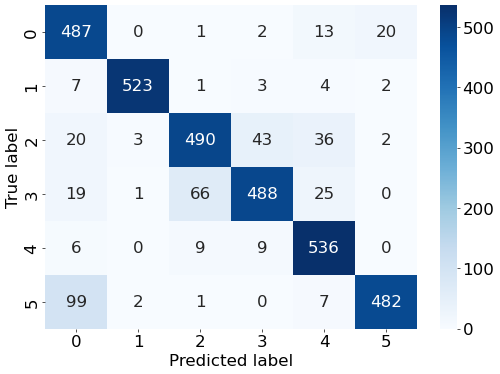

[ 각 클래스에 따른 정확도 ]
tensor([0.9312, 0.9685, 0.8249, 0.8147, 0.9571, 0.8156])
[ 전체 평균 정확도 ]
tensor(0.8823)
****************************** LightResNet56.pt ******************************
[ Train epoch: 0 ]
Train accuarcy: 49.83488662214721
Train average loss: 0.038039401896396895
[ Validation epoch: 1 ]
Accuarcy: 58.056941590842385
Average loss: 0.03420304917925294
[ Train epoch: 1 ]
Train accuarcy: 62.38350333895942
Train average loss: 0.030014749975873518
[ Validation epoch: 2 ]
Accuarcy: 67.56677428823012
Average loss: 0.027063753489773402
[ Train epoch: 2 ]
Train accuarcy: 66.96998605709254
Train average loss: 0.026825364233769158
[ Validation epoch: 3 ]
Accuarcy: 67.4200176108013
Average loss: 0.027593605445562865
[ Train epoch: 3 ]
Train accuarcy: 70.2282233800543
Train average loss: 0.02458420446808361
[ Validation epoch: 4 ]
Accuarcy: 77.92779571470501
Average loss: 0.019275613612431672
[ Train epoch: 4 ]
Train accuarcy: 72.2609525207309
Train average loss: 0.02330601736525932
[ Va

Train accuarcy: 84.24451456666911
Train average loss: 0.01371134196600071
[ Validation epoch: 45 ]
Accuarcy: 87.3202230701497
Average loss: 0.011296148937592452
[ Train epoch: 45 ]
Train accuarcy: 84.07573200264181
Train average loss: 0.01354567358741724
[ Validation epoch: 46 ]
Accuarcy: 87.96595245083651
Average loss: 0.011186440072085524
[ Train epoch: 46 ]
Train accuarcy: 84.33991340720628
Train average loss: 0.013362750839686686
[ Validation epoch: 47 ]
Accuarcy: 86.82125036689169
Average loss: 0.012350440209024562
[ Train epoch: 47 ]
Train accuarcy: 84.15645409848096
Train average loss: 0.013307500663695598
[ Validation epoch: 48 ]
Accuarcy: 87.3202230701497
Average loss: 0.011438876189267422
[ Train epoch: 48 ]
Train accuarcy: 84.69949365230792
Train average loss: 0.013066952013519774
[ Validation epoch: 49 ]
Accuarcy: 87.46697974757852
Average loss: 0.011670034316441934
[ Train epoch: 49 ]
Train accuarcy: 84.4132971306964
Train average loss: 0.013198815939527373
[ Validation ep

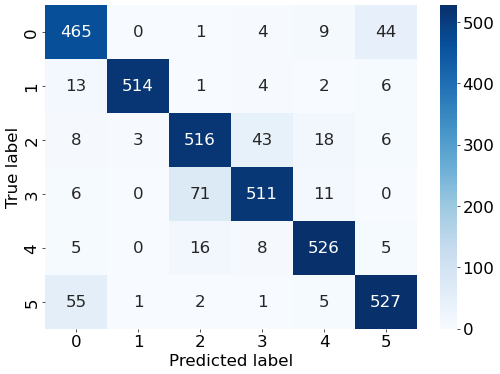

[ 각 클래스에 따른 정확도 ]
tensor([0.8891, 0.9519, 0.8687, 0.8531, 0.9393, 0.8917])
[ 전체 평균 정확도 ]
tensor(0.8979)
****************************** LightResNet56.pt ******************************
[ Train epoch: 0 ]
Train accuarcy: 49.84222499449622
Train average loss: 0.03818183606339453
[ Validation epoch: 1 ]
Accuarcy: 59.436454358673316
Average loss: 0.03153725292523795
[ Train epoch: 1 ]
Train accuarcy: 60.99655096499596
Train average loss: 0.03119577639230832
[ Validation epoch: 2 ]
Accuarcy: 65.62958614616966
Average loss: 0.027810848875412467
[ Train epoch: 2 ]
Train accuarcy: 66.34622440742643
Train average loss: 0.02786476960743463
[ Validation epoch: 3 ]
Accuarcy: 75.13941884355738
Average loss: 0.020855839087321398
[ Train epoch: 3 ]
Train accuarcy: 69.56043149629413
Train average loss: 0.02554874029304413
[ Validation epoch: 4 ]
Accuarcy: 71.3824479013795
Average loss: 0.02509693700370811
[ Train epoch: 4 ]
Train accuarcy: 71.21890364717106
Train average loss: 0.02404585242525116
[ Vali

Train accuarcy: 83.91428781096353
Train average loss: 0.013776033953813095
[ Validation epoch: 45 ]
Accuarcy: 88.14206046375111
Average loss: 0.010610513253526181
[ Train epoch: 45 ]
Train accuarcy: 84.25919131136713
Train average loss: 0.013448373892231698
[ Validation epoch: 46 ]
Accuarcy: 87.84854710889346
Average loss: 0.01129345215434968
[ Train epoch: 46 ]
Train accuarcy: 83.59139942760696
Train average loss: 0.013941661665031423
[ Validation epoch: 47 ]
Accuarcy: 87.20281772820664
Average loss: 0.011259004311859696
[ Train epoch: 47 ]
Train accuarcy: 83.77485873633228
Train average loss: 0.013755038202928676
[ Validation epoch: 48 ]
Accuarcy: 86.82125036689169
Average loss: 0.011391126927144724
[ Train epoch: 48 ]
Train accuarcy: 83.65010640639906
Train average loss: 0.013626286254364265
[ Validation epoch: 49 ]
Accuarcy: 88.34751981215145
Average loss: 0.01085083861705457
[ Train epoch: 49 ]
Train accuarcy: 84.03904014089674
Train average loss: 0.013558604012907684
[ Validation

Train accuarcy: 86.42401115432597
Train average loss: 0.011085647773351638
[ Validation epoch: 90 ]
Accuarcy: 88.5529791605518
Average loss: 0.010283436958596334
[ Train epoch: 90 ]
Train accuarcy: 86.76157628238057
Train average loss: 0.011141451123103783
[ Validation epoch: 91 ]
Accuarcy: 88.90519518638098
Average loss: 0.01018495328827166
[ Train epoch: 91 ]
Train accuarcy: 86.60013209070229
Train average loss: 0.011225170861220792
[ Validation epoch: 92 ]
Accuarcy: 86.08746697974757
Average loss: 0.01287255474451808
[ Train epoch: 92 ]
Train accuarcy: 86.45336464372203
Train average loss: 0.011459350635691872
[ Validation epoch: 93 ]
Accuarcy: 88.7290871734664
Average loss: 0.010470051729533901
[ Train epoch: 93 ]
Train accuarcy: 87.17252513392529
Train average loss: 0.011113770632520935
[ Validation epoch: 94 ]
Accuarcy: 89.34546521866744
Average loss: 0.00965715065327319
[ Train epoch: 94 ]
Train accuarcy: 87.13583327218024
Train average loss: 0.011015671878558852
[ Validation ep

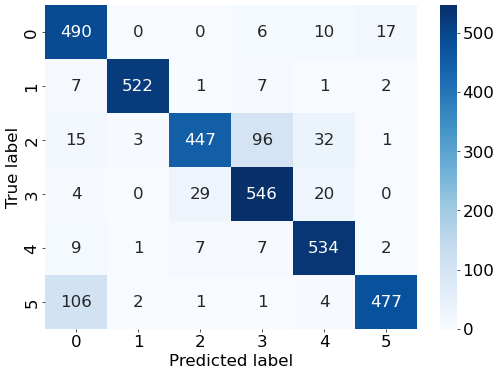

[ 각 클래스에 따른 정확도 ]
tensor([0.9369, 0.9667, 0.7525, 0.9115, 0.9536, 0.8071])
[ 전체 평균 정확도 ]
tensor(0.8852)
****************************** LightResNet110.pt ******************************
[ Train epoch: 0 ]
Train accuarcy: 47.29580978938871
Train average loss: 0.040972698502034256
[ Validation epoch: 1 ]
Accuarcy: 55.76753742295274
Average loss: 0.033910701202793415
[ Train epoch: 1 ]
Train accuarcy: 59.63161370807955
Train average loss: 0.03251925582991418
[ Validation epoch: 2 ]
Accuarcy: 71.0595832110361
Average loss: 0.024898620917715213
[ Train epoch: 2 ]
Train accuarcy: 61.92852425332061
Train average loss: 0.030744844463799367
[ Validation epoch: 3 ]
Accuarcy: 71.64660992075139
Average loss: 0.02402377814395637
[ Train epoch: 3 ]
Train accuarcy: 65.09136273574521
Train average loss: 0.02855412741089511
[ Validation epoch: 4 ]
Accuarcy: 70.32579982389198
Average loss: 0.025625424000885886
[ Train epoch: 4 ]
Train accuarcy: 67.79188376018199
Train average loss: 0.026535005466493795
[ 

Train accuarcy: 83.34923314008952
Train average loss: 0.014205770270310223
[ Validation epoch: 45 ]
Accuarcy: 84.41444085705899
Average loss: 0.014322164687971792
[ Train epoch: 45 ]
Train accuarcy: 83.26117267190138
Train average loss: 0.014209986549878739
[ Validation epoch: 46 ]
Accuarcy: 86.85060170237746
Average loss: 0.012129752828660583
[ Train epoch: 46 ]
Train accuarcy: 83.96565641740662
Train average loss: 0.013712864863143819
[ Validation epoch: 47 ]
Accuarcy: 83.915468153801
Average loss: 0.013790260089573918
[ Train epoch: 47 ]
Train accuarcy: 83.620752917003
Train average loss: 0.013881405178926885
[ Validation epoch: 48 ]
Accuarcy: 88.05400645729381
Average loss: 0.010722005556659822
[ Train epoch: 48 ]
Train accuarcy: 84.17113084317899
Train average loss: 0.013351401492790368
[ Validation epoch: 49 ]
Accuarcy: 87.96595245083651
Average loss: 0.010643525923281636
[ Train epoch: 49 ]
Train accuarcy: 83.75284361928524
Train average loss: 0.01379284046745059
[ Validation ep

KeyboardInterrupt: 

In [13]:
model_list = [20,32,56,110]
epoch_list = [70,100]
for models in model_list:
    for epoch in epoch_list:
        net = globals()[f"LightResNet{models}"]()
        net = net.to(device)
        learning_rate = 0.002
        file_name = "LightResNet"+str(models)+"diff_epoch"+str(epoch)+".pt"

        criterion = nn.CrossEntropyLoss()
        optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9, weight_decay=0.0002)

        train_result = []
        val_result = []

        start_time = time.time() # 시작 시간
        print("*"*30,"LightResNet"+str(models)+".pt","*"*30)
        for i in range(epoch):
            train_acc, train_loss = train(net, i, optimizer, criterion, train_dataloader) # 학습(training)
            val_acc, val_loss = validate(net, i + 1, val_dataloader) # 검증(validation)

            # 학습된 모델 저장하기
            state = {
                'net': net.state_dict()
            }
            if not os.path.isdir('checkpoint'):
                os.mkdir('checkpoint')
            torch.save(state, './checkpoint/' + file_name)
    #         print(f'Model saved! (time elapsed: {time.time() - start_time})')

            # 현재 epoch에서의 정확도(accuracy)와 손실(loss) 값 저장하기
            train_result.append((train_acc, train_loss))
            val_result.append((val_acc, val_loss))

        checkpoint = torch.load('./checkpoint/' + file_name)
        net.load_state_dict(checkpoint['net'])

        # 평가 데이터셋을 이용해 혼동 행렬(confusion matrix) 계산하기
        confusion_matrix = get_confusion_matrix(net, 6, val_dataloader)
        print("[ 각 클래스당 데이터 개수 ]")
        print(confusion_matrix.sum(1))

        print("[ 혼동 행렬(confusion matrix) 시각화 ]")
        res = pd.DataFrame(confusion_matrix.numpy(), index = [i for i in range(6)], columns = [i for i in range(6)])
        res.index.name = 'True label'
        res.columns.name = 'Predicted label'
        plt.figure(figsize = (10, 7))
        sns.heatmap(res, annot=True, fmt="d", cmap='Blues')
        plt.show()

        print("[ 각 클래스에 따른 정확도 ]")
        # (각 클래스마다 정답 개수 / 각 클래스마다 데이터의 개수)
        print(confusion_matrix.diag() / confusion_matrix.sum(1))

        print("[ 전체 평균 정확도 ]")
        print(confusion_matrix.diag().sum() / confusion_matrix.sum())

#### <b>(알아보기) ResNet 아키텍처 살펴보기</b>

* [ResNet (2016 CVPR)](https://arxiv.org/abs/1512.03385) 논문에서 제안된 기본적인 ResNet의 핵심 아이디어를 PyTorch로 구현한 것은 다음과 같습니다.
    * LightResNet에 비하여 <b>커널의 개수(number of kernels)가 많은</b> 것을 확인할 수 있습니다.
    * 따라서 ImageNet과 같은 큰 규모의 데이터셋에 대해서 사용하기에 적합합니다.
* (참고) [PyTorch 공식 ResNet 소스 코드](https://github.com/pytorch/vision/blob/master/torchvision/models/resnet.py)

In [33]:
# ResNet 클래스 정의
class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=6):
        super(ResNet, self).__init__()
        self.in_planes = 64

        # 64개의 3x3 필터(filter)를 사용
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        # 첫 레이어를 제외하고는 너비와 높이를 줄이기 위해 stride를 2로 설정
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1) # 첫째 블록만 너비와 높이 감소
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes # 다음 레이어를 위해 채널 수 변경
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, out.size()[3])
        out = out.view(out.size(0), -1) # 배치(batch)를 제외한 모든 차원 flatten하기
        out = self.linear(out)
        return out


def ResNet18():
    return ResNet(BasicBlock, [2, 2, 2, 2])


def ResNet34():
    return ResNet(BasicBlock, [3, 4, 6, 3])

#### <b>(알아보기) ResNet-18 학습하기</b>

* PyTorch로 구현된 ResNet-18 모델을 학습해 봅시다.

In [34]:
net = ResNet18()
net = net.to(device)

epoch = 30
learning_rate = 0.002
file_name = "ResNet18.pt"

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9, weight_decay=0.0002)

train_result = []
val_result = []

start_time = time.time() # 시작 시간

for i in range(epoch):
    train_acc, train_loss = train(net, i, optimizer, criterion, train_dataloader) # 학습(training)
    val_acc, val_loss = validate(net, i + 1, val_dataloader) # 검증(validation)

    # 학습된 모델 저장하기
    state = {
        'net': net.state_dict()
    }
    if not os.path.isdir('checkpoint'):
        os.mkdir('checkpoint')
    torch.save(state, './checkpoint/' + file_name)
    print(f'Model saved! (time elapsed: {time.time() - start_time})')

    # 현재 epoch에서의 정확도(accuracy)와 손실(loss) 값 저장하기
    train_result.append((train_acc, train_loss))
    val_result.append((val_acc, val_loss))

[ Train epoch: 0 ]
Train accuarcy: 56.24862405518456
Train average loss: 0.03457791091691217
[ Validation epoch: 1 ]
Accuarcy: 71.99882594658057
Average loss: 0.024278459833764875
Model saved! (time elapsed: 18.428807258605957)
[ Train epoch: 1 ]
Train accuarcy: 66.58839069494387
Train average loss: 0.027610605490603957
[ Validation epoch: 2 ]
Accuarcy: 76.10801291458762
Average loss: 0.02045722744455777
Model saved! (time elapsed: 36.84210753440857)
[ Train epoch: 2 ]
Train accuarcy: 71.42437807294343
Train average loss: 0.024028938982906103
[ Validation epoch: 3 ]
Accuarcy: 75.05136483710008
Average loss: 0.021014957907159973
Model saved! (time elapsed: 55.259538412094116)
[ Train epoch: 3 ]
Train accuarcy: 73.53782930945916
Train average loss: 0.022110456743077295
[ Validation epoch: 4 ]
Accuarcy: 78.30936307601996
Average loss: 0.01932901258181014
Model saved! (time elapsed: 73.48122382164001)
[ Train epoch: 4 ]
Train accuarcy: 75.56322007778675
Train average loss: 0.02075257780153

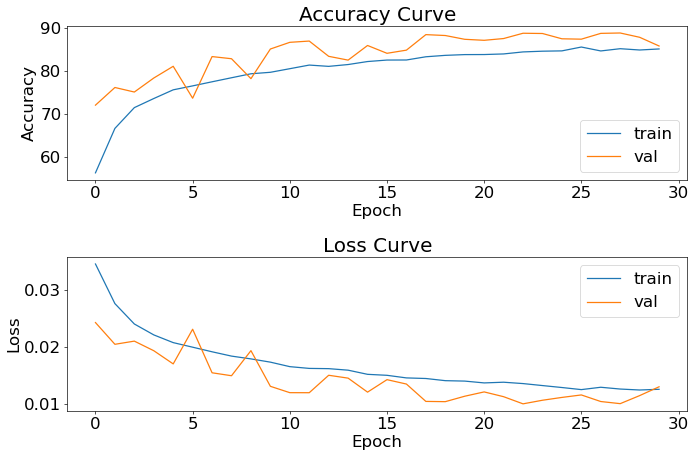

In [35]:
# 정확도(accuracy) 커브 시각화
plt.subplot(211)
plt.plot([i for i in range(epoch)], [i[0] for i in train_result])
plt.plot([i for i in range(epoch)], [i[0] for i in val_result])
plt.title("Accuracy Curve")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(["train", "val"])

# 손실(loss) 커브 시각화
plt.subplot(212)
plt.plot([i for i in range(epoch)], [i[1] for i in train_result])
plt.plot([i for i in range(epoch)], [i[1] for i in val_result])
plt.title("Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(["train", "val"])

plt.tight_layout()
plt.show()

[ 각 클래스당 데이터 개수 ]
tensor([523, 540, 594, 599, 560, 591])
[ 혼동 행렬(confusion matrix) 시각화 ]


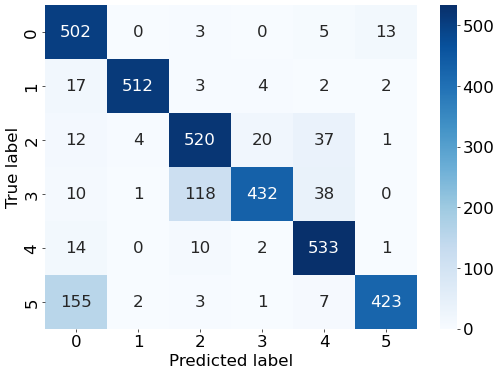

[ 각 클래스에 따른 정확도 ]
tensor([0.9598, 0.9481, 0.8754, 0.7212, 0.9518, 0.7157])
[ 전체 평균 정확도 ]
tensor(0.8576)


In [36]:
net = ResNet18()
net = net.to(device)

file_name = "./checkpoint/ResNet18.pt"
checkpoint = torch.load(file_name)
net.load_state_dict(checkpoint['net'])

# 평가 데이터셋을 이용해 혼동 행렬(confusion matrix) 계산하기
confusion_matrix = get_confusion_matrix(net, 6, val_dataloader)
print("[ 각 클래스당 데이터 개수 ]")
print(confusion_matrix.sum(1))

print("[ 혼동 행렬(confusion matrix) 시각화 ]")
res = pd.DataFrame(confusion_matrix.numpy(), index = [i for i in range(6)], columns = [i for i in range(6)])
res.index.name = 'True label'
res.columns.name = 'Predicted label'
plt.figure(figsize = (10, 7))
sns.heatmap(res, annot=True, fmt="d", cmap='Blues')
plt.show()

print("[ 각 클래스에 따른 정확도 ]")
# (각 클래스마다 정답 개수 / 각 클래스마다 데이터의 개수)
print(confusion_matrix.diag() / confusion_matrix.sum(1))

print("[ 전체 평균 정확도 ]")
print(confusion_matrix.diag().sum() / confusion_matrix.sum())

#### <b>(알아보기) Input Mixup 살펴보기</b>

* Mixup은 대표적인 데이터 증진(data augmentation) 기법으로 정확도 향상에 도움이 됩니다.
    * 일반적으로 Mixup을 사용하는 경우 더 많은 횟수(1.5배가량)의 epoch이 요구됩니다.

In [11]:
mixup_alpha = 1.0

def mixup_data(x, y):
    lam = np.random.beta(mixup_alpha, mixup_alpha)
    batch_size = x.size()[0]
    index = torch.randperm(batch_size).cuda()
    mixed_x = lam * x + (1 - lam) * x[index]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam


def mixup_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)


def train_with_mixup(net, epoch, optimizer, criterion, train_dataloader):
    print('[ Train epoch: %d ]' % epoch)
    net.train() # 모델을 학습 모드로 설정
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(train_dataloader):
        inputs, targets = inputs.to(device), targets.to(device)
        inputs, targets_a, targets_b, lam = mixup_data(inputs, targets) # Mixup 진행
        optimizer.zero_grad() # 기울기(gradient) 초기화

        outputs = net(inputs) # 모델 입력하여 결과 계산
        loss = mixup_criterion(criterion, outputs, targets_a, targets_b, lam) # 손실(loss) 값 계산
        loss.backward() # 역전파를 통해 기울기(gradient) 계산

        optimizer.step() # 계산된 기울기를 이용해 모델 가중치 업데이트
        train_loss += loss.item()
        _, predicted = outputs.max(1)

        total += targets.size(0)
        correct += (lam * predicted.eq(targets_a).sum().item() + (1 - lam) * predicted.eq(targets_b).sum().item())

    print('Train accuarcy:', 100. * correct / total)
    print('Train average loss:', train_loss / total)
    return (100. * correct / total, train_loss / total)

#### <b>Problem 6. Mixup 결과 분석하기</b>

* Mixup을 사용하여 ResNet-18에 대하여 50번 epoch만큼 학습을 진행한 뒤에 성능이 얼마나 개선되었는지 쓰세요.
    * Mixup을 적용했을 때의 검증 정확도(validation accuracy): {0.8937, 0.8882에서 0.005 증가함}

In [38]:
net = ResNet18()
net = net.to(device)

epoch = 50
learning_rate = 0.002
file_name = "ResNet18_Mixup.pt"

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9, weight_decay=0.0002)

train_result = []
val_result = []

start_time = time.time() # 시작 시간

for i in range(epoch):
    train_acc, train_loss = train_with_mixup(net, i, optimizer, criterion, train_dataloader) # 학습(training)
    val_acc, val_loss = validate(net, i + 1, val_dataloader) # 검증(validation)

    # 학습된 모델 저장하기
    state = {
        'net': net.state_dict()
    }
    if not os.path.isdir('checkpoint'):
        os.mkdir('checkpoint')
    torch.save(state, './checkpoint/' + file_name)
    print(f'Model saved! (time elapsed: {time.time() - start_time})')

    # 현재 epoch에서의 정확도(accuracy)와 손실(loss) 값 저장하기
    train_result.append((train_acc, train_loss))
    val_result.append((val_acc, val_loss))

[ Train epoch: 0 ]
Train accuarcy: 43.19206383082496
Train average loss: 0.045213963985968
[ Validation epoch: 1 ]
Accuarcy: 55.82624009392428
Average loss: 0.03368953443322323
Model saved! (time elapsed: 18.48529553413391)
[ Train epoch: 1 ]
Train accuarcy: 51.55413210385664
Train average loss: 0.04070695023758182
[ Validation epoch: 2 ]
Accuarcy: 61.432345171705315
Average loss: 0.032686753972100836
Model saved! (time elapsed: 36.924994707107544)
[ Train epoch: 2 ]
Train accuarcy: 54.90405003587205
Train average loss: 0.03873869438396036
[ Validation epoch: 3 ]
Accuarcy: 73.7892574112122
Average loss: 0.02542584287759878
Model saved! (time elapsed: 55.421435832977295)
[ Train epoch: 3 ]
Train accuarcy: 55.64571375104399
Train average loss: 0.038244790058803636
[ Validation epoch: 4 ]
Accuarcy: 75.2861755209862
Average loss: 0.02302275925638531
Model saved! (time elapsed: 73.9205572605133)
[ Train epoch: 4 ]
Train accuarcy: 56.883551339101956
Train average loss: 0.037355986735507066
[

Train accuarcy: 65.17705560715004
Train average loss: 0.030486156909054807
[ Validation epoch: 37 ]
Accuarcy: 85.35368359260346
Average loss: 0.015117421094574186
Model saved! (time elapsed: 681.9143002033234)
[ Train epoch: 37 ]
Train accuarcy: 65.69226521355144
Train average loss: 0.03030066974332592
[ Validation epoch: 38 ]
Accuarcy: 88.14206046375111
Average loss: 0.013168636539971195
Model saved! (time elapsed: 699.8357479572296)
[ Train epoch: 38 ]
Train accuarcy: 65.91226523723178
Train average loss: 0.030162289459811902
[ Validation epoch: 39 ]
Accuarcy: 89.0519518638098
Average loss: 0.013129040520142908
Model saved! (time elapsed: 717.7821612358093)
[ Train epoch: 39 ]
Train accuarcy: 65.1255345442463
Train average loss: 0.030721449198949938
[ Validation epoch: 40 ]
Accuarcy: 87.26152039917817
Average loss: 0.012976286442426072
Model saved! (time elapsed: 735.8830330371857)
[ Train epoch: 40 ]
Train accuarcy: 66.00533559932265
Train average loss: 0.030325791902619796
[ Valida

[ 각 클래스당 데이터 개수 ]
tensor([523, 540, 594, 599, 560, 591])
[ 혼동 행렬(confusion matrix) 시각화 ]


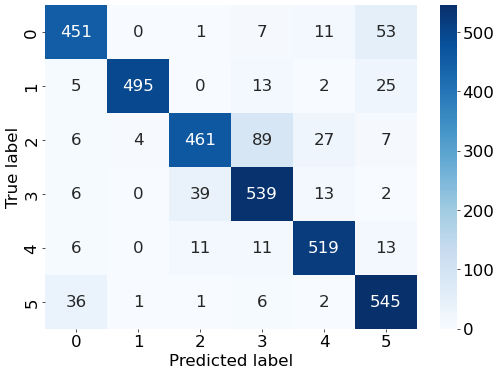

[ 각 클래스에 따른 정확도 ]
tensor([0.8623, 0.9167, 0.7761, 0.8998, 0.9268, 0.9222])
[ 전체 평균 정확도 ]
tensor(0.8835)


In [39]:
checkpoint = torch.load( './checkpoint/' + file_name)
net.load_state_dict(checkpoint['net'])

# 평가 데이터셋을 이용해 혼동 행렬(confusion matrix) 계산하기
confusion_matrix = get_confusion_matrix(net, 6, val_dataloader)
print("[ 각 클래스당 데이터 개수 ]")
print(confusion_matrix.sum(1))

print("[ 혼동 행렬(confusion matrix) 시각화 ]")
res = pd.DataFrame(confusion_matrix.numpy(), index = [i for i in range(6)], columns = [i for i in range(6)])
res.index.name = 'True label'
res.columns.name = 'Predicted label'
plt.figure(figsize = (10, 7))
sns.heatmap(res, annot=True, fmt="d", cmap='Blues')
plt.show()

print("[ 각 클래스에 따른 정확도 ]")
# (각 클래스마다 정답 개수 / 각 클래스마다 데이터의 개수)
print(confusion_matrix.diag() / confusion_matrix.sum(1))

print("[ 전체 평균 정확도 ]")
print(confusion_matrix.diag().sum() / confusion_matrix.sum())

#### <b>(알아보기) Transfer Learning 살펴보기</b>

* 전이 학습(Transfer Learning)은 <b>단기간에 우수한 정확도</b>를 얻기 위해 효과적으로 사용할 수 있는 기법입니다.
    * 본 실습에서는 미세 조정(fine-tuning) 기법을 사용합니다.
    * 적은 epoch만으로도 빠르게 수렴합니다.
* 전이 학습을 위해서는, 사전 학습된(pre-trained) 네트워크와 동일한 크기의 입력 차원을 갖도록 <b>데이터셋을 수정</b>해야 합니다.
    * ResNet 특성상 데이터셋 수정 없이도 동작할 수 있지만, 일반적으로 데이터셋을 수정합니다.
* (참고) [PyTorch 공식 Transfer Learning 튜토리얼](https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html)
* 기본적인 Transfer Learning을 이용해 91~93%의 정확도를 얻을 수 있습니다.

In [12]:
transforms_train_transferred = transforms.Compose([
    transforms.RandomResizedCrop((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # 정규화(normalization)
])

transforms_val_transferred = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_dataset_transferred = datasets.ImageFolder(train_path, transforms_train_transferred)
val_dataset_transferred = datasets.ImageFolder(val_path, transforms_val_transferred)

train_dataloader_transferred = torch.utils.data.DataLoader(train_dataset_transferred, batch_size=16, shuffle=True, num_workers=2)
val_dataloader_transferred = torch.utils.data.DataLoader(val_dataset_transferred, batch_size=16, shuffle=True, num_workers=2)

print('Training dataset size:', len(train_dataset_transferred))
print('Validation dataset size:', len(val_dataset_transferred))

class_names = train_dataset_transferred.classes
print('Class names:', class_names)

Training dataset size: 13627
Validation dataset size: 3407
Class names: ['buildings', 'forests', 'glacier', 'mountains', 'sea', 'street']


In [41]:
net = torchvision.models.resnet18(pretrained=True)

# 마지막 레이어의 차원을 6차원으로 조절
num_features = net.fc.in_features
net.fc = nn.Linear(num_features, 6)
net = net.to(device)

epoch = 20
learning_rate = 0.001 # 일반적으로 fine-tuning을 진행할 때는 학습률(learning rate)을 낮게 설정
file_name = "ResNet18Transferred.pt"

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9, weight_decay=0.0002)

train_result = []
val_result = []

start_time = time.time() # 시작 시간

for i in range(epoch):
    train_acc, train_loss = train(net, i, optimizer, criterion, train_dataloader_transferred) # 학습(training)
    val_acc, val_loss = validate(net, i + 1, val_dataloader_transferred) # 검증(validation)

    # 학습된 모델 저장하기
    state = {
        'net': net.state_dict()
    }
    if not os.path.isdir('checkpoint'):
        os.mkdir('checkpoint')
    torch.save(state, './checkpoint/' + file_name)
    print(f'Model saved! (time elapsed: {time.time() - start_time})')

    # 현재 epoch에서의 정확도(accuracy)와 손실(loss) 값 저장하기
    train_result.append((train_acc, train_loss))
    val_result.append((val_acc, val_loss))

[ Train epoch: 0 ]


C:\Users\USER\anaconda3\envs\SU\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
C:\Users\USER\anaconda3\envs\SU\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Train accuarcy: 77.43450502678506
Train average loss: 0.03853718226951444
[ Validation epoch: 1 ]
Accuarcy: 88.84649251540945
Average loss: 0.019084262777265302
Model saved! (time elapsed: 21.313689947128296)
[ Train epoch: 1 ]
Train accuarcy: 82.07235635136126
Train average loss: 0.03044704264523987
[ Validation epoch: 2 ]
Accuarcy: 90.43146463164074
Average loss: 0.017057264520558998
Model saved! (time elapsed: 42.358012437820435)
[ Train epoch: 2 ]
Train accuarcy: 84.47934248183753
Train average loss: 0.026952084256133112
[ Validation epoch: 3 ]
Accuarcy: 91.19459935427062
Average loss: 0.015625813616194226
Model saved! (time elapsed: 63.57290530204773)
[ Train epoch: 3 ]
Train accuarcy: 85.00036691861744
Train average loss: 0.02519044731368084
[ Validation epoch: 4 ]
Accuarcy: 91.5468153800998
Average loss: 0.014970331688692816
Model saved! (time elapsed: 84.87837171554565)
[ Train epoch: 4 ]
Train accuarcy: 86.48271813311807
Train average loss: 0.023014793029639886
[ Validation ep

[ 각 클래스당 데이터 개수 ]
tensor([523, 540, 594, 599, 560, 591])
[ 혼동 행렬(confusion matrix) 시각화 ]


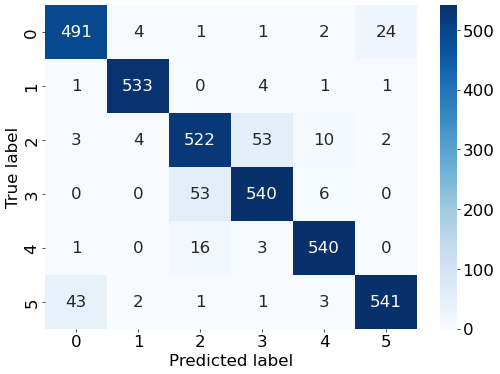

[ 각 클래스에 따른 정확도 ]
tensor([0.9388, 0.9870, 0.8788, 0.9015, 0.9643, 0.9154])
[ 전체 평균 정확도 ]
tensor(0.9296)


In [42]:
checkpoint = torch.load( './checkpoint/ResNet18Transferred.pt')
net.load_state_dict(checkpoint['net'])

# 평가 데이터셋을 이용해 혼동 행렬(confusion matrix) 계산하기
confusion_matrix = get_confusion_matrix(net, 6, val_dataloader_transferred)
print("[ 각 클래스당 데이터 개수 ]")
print(confusion_matrix.sum(1))

print("[ 혼동 행렬(confusion matrix) 시각화 ]")
res = pd.DataFrame(confusion_matrix.numpy(), index = [i for i in range(6)], columns = [i for i in range(6)])
res.index.name = 'True label'
res.columns.name = 'Predicted label'
plt.figure(figsize = (10, 7))
sns.heatmap(res, annot=True, fmt="d", cmap='Blues')
plt.show()

print("[ 각 클래스에 따른 정확도 ]")
# (각 클래스마다 정답 개수 / 각 클래스마다 데이터의 개수)
print(confusion_matrix.diag() / confusion_matrix.sum(1))

print("[ 전체 평균 정확도 ]")
print(confusion_matrix.diag().sum() / confusion_matrix.sum())

#### <b>Problem 7. State-of-the-Art 성능 만들기</b>

* SOTA 수준의 성능을 만들어 보세요.
* (참고) Transfer Learning과 Mixup을 함께 사용해 보세요.
    * 더 큰 규모의 사전 학습된 모델(ResNet-50 이상)을 이용해 보세요.
* (참고) learning rate scheduler를 사용해 보세요.

<pre>
def adjust_learning_rate(optimizer, epoch):
    lr = learning_rate
    if epoch >= 20:
        lr /= 8
    if epoch >= 40:
        lr /= 8
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr
</pre>

* 대회(competition)에 참여하고 있다고 생각하고, <b>94% 이상의 정확도</b>를 만들어 보세요.
    * 내 모델의 검증 정확도(validation accuracy): {94.31}


#### ResNet-50,101,152 + Transfer Learning + Mixup + Learning rate scheduler

C:\Users\USER\anaconda3\envs\SU\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


[ Train epoch: 0 ]
Train accuarcy: 59.112611455016506
Train average loss: 0.072232234711569
[ Validation epoch: 1 ]
Accuarcy: 88.87584385089522
Average loss: 0.02490378691018555
Model saved! (time elapsed: 52.51776957511902)
[ Train epoch: 1 ]
Train accuarcy: 64.56431940470958
Train average loss: 0.06501149381957541
[ Validation epoch: 2 ]
Accuarcy: 89.43351922512474
Average loss: 0.024059145059409225
Model saved! (time elapsed: 104.72242045402527)
[ Train epoch: 2 ]
Train accuarcy: 66.51786975673163
Train average loss: 0.0616816405378872
[ Validation epoch: 3 ]
Accuarcy: 91.34135603169945
Average loss: 0.02130301625175073
Model saved! (time elapsed: 157.0812349319458)
[ Train epoch: 3 ]
Train accuarcy: 66.85004811214827
Train average loss: 0.060634750009256666
[ Validation epoch: 4 ]
Accuarcy: 91.19459935427062
Average loss: 0.021233272344302598
Model saved! (time elapsed: 209.43354558944702)
[ Train epoch: 4 ]
Train accuarcy: 67.27491515146846
Train average loss: 0.05969966629823095


Train accuarcy: 71.22612229301053
Train average loss: 0.05240670395363731
[ Validation epoch: 37 ]
Accuarcy: 93.4546521866745
Average loss: 0.015515031328570784
Model saved! (time elapsed: 1940.1437199115753)
[ Train epoch: 37 ]
Train accuarcy: 70.44426471697784
Train average loss: 0.05328034367071976
[ Validation epoch: 38 ]
Accuarcy: 93.71881420604637
Average loss: 0.015673940185056183
Model saved! (time elapsed: 1992.6214454174042)
[ Train epoch: 38 ]
Train accuarcy: 69.98751238814215
Train average loss: 0.05373643870997378
[ Validation epoch: 39 ]
Accuarcy: 93.63076019958908
Average loss: 0.01627508947357321
Model saved! (time elapsed: 2045.059842824936)
[ Train epoch: 39 ]
Train accuarcy: 70.93195464784358
Train average loss: 0.052831426185216836
[ Validation epoch: 40 ]
Accuarcy: 93.3665981802172
Average loss: 0.01609346428670105
Model saved! (time elapsed: 2097.5256752967834)
[ Train epoch: 40 ]
Train accuarcy: 71.11118270566072
Train average loss: 0.05268014873072276
[ Validati

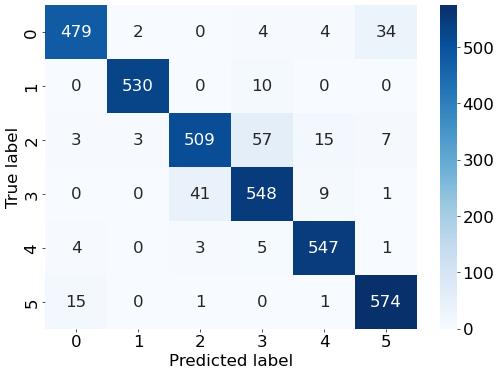

[ 각 클래스에 따른 정확도 ]
tensor([0.9159, 0.9815, 0.8569, 0.9149, 0.9768, 0.9712])
[ 전체 평균 정확도 ]
tensor(0.9354)


C:\Users\USER\anaconda3\envs\SU\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
C:\Users\USER\anaconda3\envs\SU\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


[ Train epoch: 0 ]
Train accuarcy: 59.75640158791305
Train average loss: 0.07220578915813729
[ Validation epoch: 1 ]
Accuarcy: 89.1400058702671
Average loss: 0.022280916674398837
Model saved! (time elapsed: 83.95816969871521)
[ Train epoch: 1 ]
Train accuarcy: 64.66726873495519
Train average loss: 0.06469077996648818
[ Validation epoch: 2 ]
Accuarcy: 90.49016730261226
Average loss: 0.02207924238189351
Model saved! (time elapsed: 166.44824647903442)
[ Train epoch: 2 ]
Train accuarcy: 65.91386288828527
Train average loss: 0.062319936597785536
[ Validation epoch: 3 ]
Accuarcy: 90.37276196066921
Average loss: 0.021792284158062017
Model saved! (time elapsed: 251.38005542755127)
[ Train epoch: 3 ]
Train accuarcy: 66.34571665406358
Train average loss: 0.06157888474595287
[ Validation epoch: 4 ]
Accuarcy: 90.4608159671265
Average loss: 0.020312836347243495
Model saved! (time elapsed: 336.4987156391144)
[ Train epoch: 4 ]
Train accuarcy: 66.56156430046602
Train average loss: 0.06050935091709560

Train accuarcy: 70.93811149409242
Train average loss: 0.05284988581631236
[ Validation epoch: 37 ]
Accuarcy: 94.07103023187555
Average loss: 0.015028674060345956
Model saved! (time elapsed: 3145.512955188751)
[ Train epoch: 37 ]
Train accuarcy: 71.64799902301286
Train average loss: 0.05208176356611331
[ Validation epoch: 38 ]
Accuarcy: 94.07103023187555
Average loss: 0.014930284622261732
Model saved! (time elapsed: 3227.548891544342)
[ Train epoch: 38 ]
Train accuarcy: 71.57303863143682
Train average loss: 0.05122699771753592
[ Validation epoch: 39 ]
Accuarcy: 94.04167889638978
Average loss: 0.01432260997223826
Model saved! (time elapsed: 3308.398137331009)
[ Train epoch: 39 ]
Train accuarcy: 71.09016775275029
Train average loss: 0.052488417210268014
[ Validation epoch: 40 ]
Accuarcy: 94.01232756090403
Average loss: 0.0147011574999587
Model saved! (time elapsed: 3391.30241894722)
[ Train epoch: 40 ]
Train accuarcy: 71.91984473239944
Train average loss: 0.05129549317890229
[ Validation 

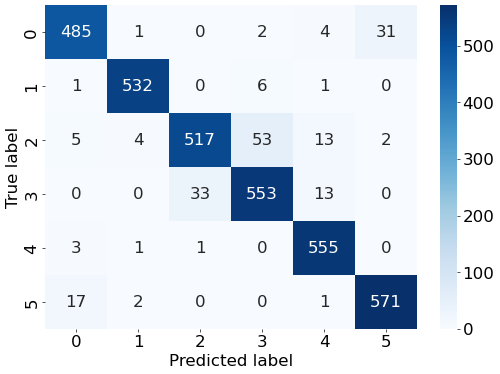

[ 각 클래스에 따른 정확도 ]
tensor([0.9273, 0.9852, 0.8704, 0.9232, 0.9911, 0.9662])
[ 전체 평균 정확도 ]
tensor(0.9431)


C:\Users\USER\anaconda3\envs\SU\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
C:\Users\USER\anaconda3\envs\SU\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


[ Train epoch: 0 ]
Train accuarcy: 59.465927426049696
Train average loss: 0.07220344431438615
[ Validation epoch: 1 ]
Accuarcy: 86.99735837980629
Average loss: 0.02629804301986185
Model saved! (time elapsed: 107.62963819503784)
[ Train epoch: 1 ]
Train accuarcy: 65.01979928337217
Train average loss: 0.06406763974128032
[ Validation epoch: 2 ]
Accuarcy: 89.69768124449662
Average loss: 0.02299655766161019
Model saved! (time elapsed: 215.97900009155273)
[ Train epoch: 2 ]
Train accuarcy: 66.68585191512366
Train average loss: 0.061005682538293506
[ Validation epoch: 3 ]
Accuarcy: 89.40416788963898
Average loss: 0.021078891183996185
Model saved! (time elapsed: 323.6861312389374)
[ Train epoch: 3 ]
Train accuarcy: 66.97204724619768
Train average loss: 0.060097353679029644
[ Validation epoch: 4 ]
Accuarcy: 89.58027590255357
Average loss: 0.02184448447838395
Model saved! (time elapsed: 431.61407947540283)
[ Train epoch: 4 ]
Train accuarcy: 67.87551152829738
Train average loss: 0.05857136414803

Train accuarcy: 71.36004553273877
Train average loss: 0.051760197367043195
[ Validation epoch: 37 ]
Accuarcy: 93.42530085118872
Average loss: 0.015476534544923
Model saved! (time elapsed: 4076.190570116043)
[ Train epoch: 37 ]
Train accuarcy: 70.89758117198183
Train average loss: 0.05242982021236819
[ Validation epoch: 38 ]
Accuarcy: 93.16113883181684
Average loss: 0.015174687675211063
Model saved! (time elapsed: 4187.889853954315)
[ Train epoch: 38 ]
Train accuarcy: 71.39983989753175
Train average loss: 0.05188720821875018
[ Validation epoch: 39 ]
Accuarcy: 93.3665981802172
Average loss: 0.01501621502758577
Model saved! (time elapsed: 4299.557870388031)
[ Train epoch: 39 ]
Train accuarcy: 71.75635206410388
Train average loss: 0.0512508980805739
[ Validation epoch: 40 ]
Accuarcy: 93.48400352216026
Average loss: 0.014863675340489624
Model saved! (time elapsed: 4409.529557228088)
[ Train epoch: 40 ]
Train accuarcy: 71.07092003323885
Train average loss: 0.052015218923392295
[ Validation e

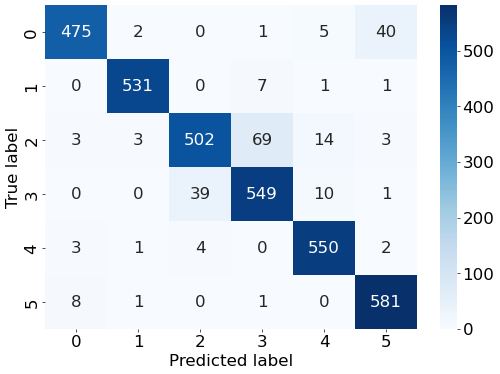

[ 각 클래스에 따른 정확도 ]
tensor([0.9082, 0.9833, 0.8451, 0.9165, 0.9821, 0.9831])
[ 전체 평균 정확도 ]
tensor(0.9357)


In [55]:
model_list = [50,101,152]
for models in model_list:
    exec(f"net = torchvision.models.resnet{models}(pretrained=True)")
    # 마지막 레이어의 차원을 6차원으로 조절
    num_features = net.fc.in_features
    net.fc = nn.Linear(num_features, 6)
    net = net.to(device)

    epoch = 50
    learning_rate = 0.001
    file_name = "ResNet"+str(models)+"Transferred_mixup.pt"

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9, weight_decay=0.0002)
    scheduler1 = optim.lr_scheduler.MultiStepLR(optimizer, milestones=np.arange(10,epoch), gamma=0.5)
    scheduler2 = optim.lr_scheduler.MultiStepLR(optimizer, milestones=np.arange(20,epoch), gamma=0.5)
    scheduler3 = optim.lr_scheduler.MultiStepLR(optimizer, milestones=np.arange(30,epoch), gamma=0.5)
    scheduler4 = optim.lr_scheduler.MultiStepLR(optimizer, milestones=np.arange(40,epoch), gamma=0.5)
    train_result = []
    val_result = []

    start_time = time.time() # 시작 시간

    for i in range(epoch):
        train_acc, train_loss = train_with_mixup(net, i, optimizer, criterion, train_dataloader_transferred) # 학습(training)
        val_acc, val_loss = validate(net, i + 1, val_dataloader_transferred) # 검증(validation)
        # 학습된 모델 저장하기
        state = {
            'net': net.state_dict()
        }

        if not os.path.isdir('checkpoint'):
            os.mkdir('checkpoint')
        torch.save(state, './checkpoint/' + file_name)
        print(f'Model saved! (time elapsed: {time.time() - start_time})')
        scheduler1.step()
        scheduler2.step()
        scheduler3.step()
        scheduler4.step()

        # 현재 epoch에서의 정확도(accuracy)와 손실(loss) 값 저장하기
        train_result.append((train_acc, train_loss))
        val_result.append((val_acc, val_loss))

    checkpoint = torch.load('./checkpoint/' + file_name)
    net.load_state_dict(checkpoint['net'])

    # 평가 데이터셋을 이용해 혼동 행렬(confusion matrix) 계산하기
    confusion_matrix = get_confusion_matrix(net, 6, val_dataloader_transferred)
    print("[ 각 클래스당 데이터 개수 ]")
    print(confusion_matrix.sum(1))

    print("[ 혼동 행렬(confusion matrix) 시각화 ]")
    res = pd.DataFrame(confusion_matrix.numpy(), index = [i for i in range(6)], columns = [i for i in range(6)])
    res.index.name = 'True label'
    res.columns.name = 'Predicted label'
    plt.figure(figsize = (10, 7))
    sns.heatmap(res, annot=True, fmt="d", cmap='Blues')
    plt.show()

    print("[ 각 클래스에 따른 정확도 ]")
    # (각 클래스마다 정답 개수 / 각 클래스마다 데이터의 개수)
    print(confusion_matrix.diag() / confusion_matrix.sum(1))

    print("[ 전체 평균 정확도 ]")
    print(confusion_matrix.diag().sum() / confusion_matrix.sum())